In [1]:
# Inspired by notebook from Aguiar
# Func: Extract all features, flatten json columns
# with multiprocessing module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gc
import sys
import math
from pandas.io.json import json_normalize
from datetime import datetime
import os
import time
from datetime import datetime
from ast import literal_eval
import multiprocessing
import glob
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
%time train_df = pd.read_csv("./data/my_train.csv",low_memory=False)

CPU times: user 55 s, sys: 3.17 s, total: 58.1 s
Wall time: 58.1 s


In [3]:
%time test_df = pd.read_csv("./data/my_test.csv",low_memory=False)

CPU times: user 12.2 s, sys: 496 ms, total: 12.7 s
Wall time: 12.7 s


In [10]:
# Find columns with "No" for date
for df in test_df,train_df:
    index = df[df['date']=='No'].index
    print( index)
    df.drop(index,inplace=True,axis=0)
print(train_df.shape)
print(test_df.shape)

Int64Index([311246], dtype='int64')
Int64Index([126874, 417420, 535819, 970784, 1154563, 1193749, 1285519, 1289856], dtype='int64')
(1708337, 148)
(401589, 148)


In [11]:
# Find columne that is constant
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False) < 2]
const_cols

['device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'socialEngagementType',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [12]:
# find columns difference
col1 = [c for c in train_df.columns if c not in test_df.columns]
col2 = [c for c in test_df.columns if c not in train_df.columns]
print(col1)
print(col2)

[]
[]


In [13]:
# Drop empty columnes
def drop_cols(df,cols):
    for col in cols:
        if col in df.columns:
            print("dropping for ",col)
            df.drop(col,axis=1,inplace=True)
drop_cols(train_df,const_cols + ['trafficSource.campaignCode'])
drop_cols(test_df,const_cols)

dropping for  device.browserSize
dropping for  device.browserVersion
dropping for  device.flashVersion
dropping for  device.language
dropping for  device.mobileDeviceBranding
dropping for  device.mobileDeviceInfo
dropping for  device.mobileDeviceMarketingName
dropping for  device.mobileDeviceModel
dropping for  device.mobileInputSelector
dropping for  device.operatingSystemVersion
dropping for  device.screenColors
dropping for  device.screenResolution
dropping for  geoNetwork.cityId
dropping for  geoNetwork.latitude
dropping for  geoNetwork.longitude
dropping for  geoNetwork.networkLocation
dropping for  socialEngagementType
dropping for  totals.visits
dropping for  trafficSource.adwordsClickInfo.criteriaParameters
dropping for  device.browserSize
dropping for  device.browserVersion
dropping for  device.flashVersion
dropping for  device.language
dropping for  device.mobileDeviceBranding
dropping for  device.mobileDeviceInfo
dropping for  device.mobileDeviceMarketingName
dropping for  d

In [14]:
print(train_df.shape)
print(test_df.shape)

(1708337, 129)
(401589, 129)


In [15]:
from datetime import datetime
test_df['new_date'] = test_df['date'].apply(lambda x: datetime.strptime(x,"%Y%m%d"))
train_df['new_date'] = train_df['date'].apply(lambda x: datetime.strptime(x,"%Y%m%d"))

In [ ]:
train_df['new_date'].hist()
beg = train_df['new_date'].min()
end = train_df['new_date'].max()
print(" train beg is {0} end is {1} len is {2}".format(beg,end,end-beg))

In [ ]:
train_uniq_date = train_df['new_date'].apply(lambda x: x.strftime("%Y%m")).unique()

In [ ]:
train_uniq_date

In [ ]:
test_df['new_date'].hist(bins=100)
test_df['new_date'].min()
test_df['new_date'].max()

In [ ]:
test_uniq_date = test_df['new_date'].apply(lambda x: x.strftime("%Y%m")).unique()

In [ ]:
test_uniq_date

In [16]:
def print_df_shape():
    print("Test shape is ", test_df.shape)
    print('Train shape is', train_df.shape)
print_df_shape()

Test shape is  (401589, 130)
Train shape is (1708337, 130)


In [ ]:
# Clean up each columns
train_df.columns.values

In [17]:
# Drop deprecated column totals_transactionRevenue
to_drop = ['totals.transactionRevenue']
drop_cols(train_df,to_drop)
drop_cols(test_df,to_drop)

dropping for  totals.transactionRevenue
dropping for  totals.transactionRevenue


In [18]:
target = 'totals.totalTransactionRevenue'
# fillna target
for df in train_df,test_df:
    df[target] = df[target].fillna(0)

In [19]:
def check_me2(feat,train_df):
    # two plots needed for non-zero revenue cases
    # 1. plot of relationship between feature and target, we only show the top 10
    # 2. plot the frequency of each dimension of current feature, based on the same 10 
    # categories we show in #1

    no_zero_df = train_df[train_df[target] > 0]
    unique_num = no_zero_df.groupby(feat)[feat].count().shape[0]
    unique_num_all = train_df.groupby(feat)[feat].count().shape[0]
    
    ## print features with frequency > 0.001
    freq = train_df.groupby(feat)[feat].count() / train_df.shape[0]
    freq_feat = freq[freq.values > 0.001].index
    print("------> freq > 0.001 feature is: ",freq_feat.T)
    
    
    print(" -----> Unique Feature with Revenue/All:",unique_num,unique_num_all)
    meta = check_meta_df(train_df,feat)
    print(meta)
    

    if unique_num_all > 400:
        print("Current feature have more then 100 dimensions, break")
        return
    #     print(no_zero_df.groupby(feat)[target].sum())
    fig,([ax1,ax3],[ax2,ax4]) = plt.subplots(nrows=2,ncols=2)
    fig.subplots_adjust(hspace=0.6)
    plt.title(feat)
    no_zero_df.groupby(feat)[target].sum().plot(x=feat,y=target,kind='bar',figsize=(12,10)
                                   ,ax=ax1)
    ax1.set_ylabel('withRevenue Sum')
    no_zero_df.groupby(feat)[feat].count().plot(ax=ax2,kind='bar')
    ax2.set_ylabel("withRevenue FeatFreq")
    train_df.groupby(feat)[target].sum().plot(x=feat,y=target,kind='bar'
                                   ,ax=ax3)
    ax3.set_ylabel('all Sum')
    train_df.groupby(feat)[feat].count().plot(ax=ax4,kind='bar')
    ax4.set_ylabel('all freq')
def check_meta_df(df,feat):
    # this function prints the meta info that I would like to see for each feature
    meta_feat = ['type','uniqueCount','NonPer','q01count','q05count','min','max','mean']
    meta = pd.DataFrame(columns=meta_feat)
    col_name = feat
    col = df[col_name]
    #         print('--> on: ',col_name)
    meta.at[col_name,'type'] = col.dtypes
    meta.at[col_name,'NonPer'] = col.isnull().sum()/col.shape[0] * 100 
    meta.at[col_name,'uniqueCount'] = col.unique().shape[0]
    print("====>> Unique:",col.unique())

    freq = df.groupby(col_name)[col_name].count() / df.shape[0]
    meta.at[col_name,'q01count'] = (freq < 0.001).sum() / freq.shape[0]
    meta.at[col_name,'q05count'] = (freq < 0.005).sum() / freq.shape[0]
    if 'float' in str(df[col_name].dtype) or 'int' in str(df[col_name].dtype):
        meta.at[col_name,'min'] = col.min()
        meta.at[col_name,'max'] = col.max()
        meta.at[col_name,'mean'] = col.mean()
        meta.at[col_name,'skewness'] = col.skew()        
    print(meta)
    
def fill_df_na(col,fill_value):
    for df in train_df,test_df:
        df[col].fillna(fill_value,inplace=True)

In [20]:
cat_cols = []
num_cols = []
more_cols = []
to_drop = []

----> Work on feature: channelGrouping
------> freq > 0.001 feature is:  Index(['Affiliates', 'Direct', 'Display', 'Organic Search', 'Paid Search', 'Referral', 'Social'], dtype='object', name='channelGrouping')
 -----> Unique Feature with Revenue/All: 8 8
====>> Unique: ['Organic Search' 'Social' 'Direct' 'Referral' 'Paid Search' 'Display'
 'Affiliates' '(Other)']
                   type uniqueCount NonPer q01count q05count  min  max mean
channelGrouping  object           8      0    0.125    0.125  NaN  NaN  NaN
None


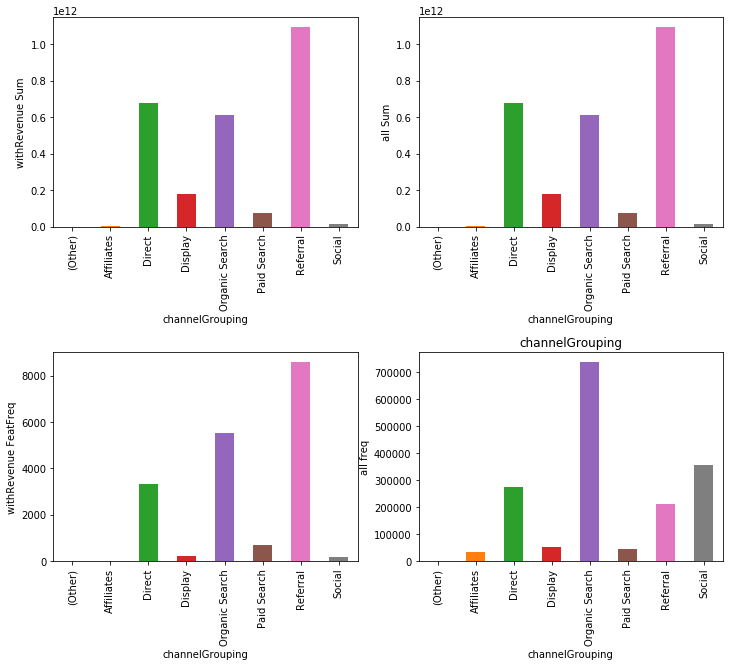

In [21]:
feat_num = 0
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)

cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)

----> Work on feature: customDimensions_index
------> freq > 0.001 feature is:  Float64Index([0.0, 4.0], dtype='float64', name='customDimensions_index')
 -----> Unique Feature with Revenue/All: 2 2
====>> Unique: [4. 0.]
                           type uniqueCount NonPer q01count q05count min max     mean  skewness
customDimensions_index  float64           2      0        0        0   0   4  3.21974 -1.539111
None


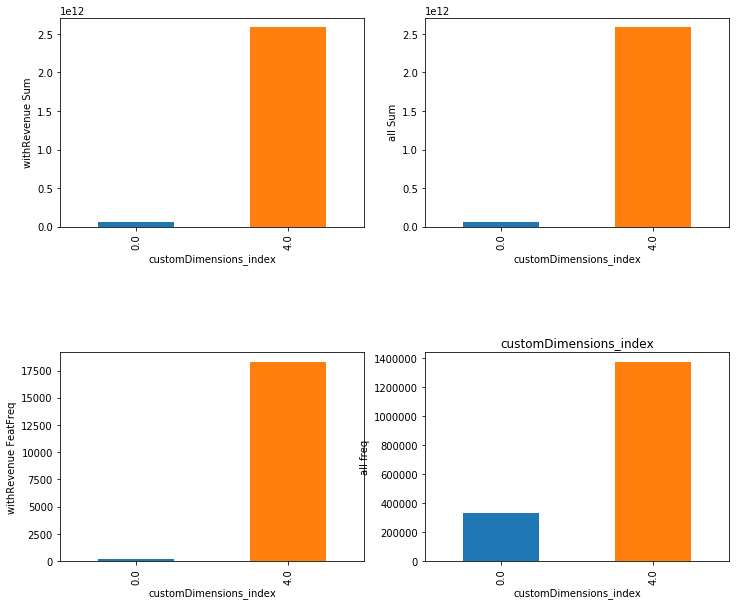

In [23]:
feat_num = 1
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,0)

----> Work on feature: customDimensions_value
------> freq > 0.001 feature is:  Index(['APAC', 'Central America', 'EMEA', 'North America', 'South America', 'other'], dtype='object', name='customDimensions_value')
 -----> Unique Feature with Revenue/All: 6 6
====>> Unique: ['EMEA' 'South America' 'North America' 'APAC' 'other' 'Central America']
                          type uniqueCount NonPer q01count q05count  min  max mean
customDimensions_value  object           6      0        0        0  NaN  NaN  NaN
None


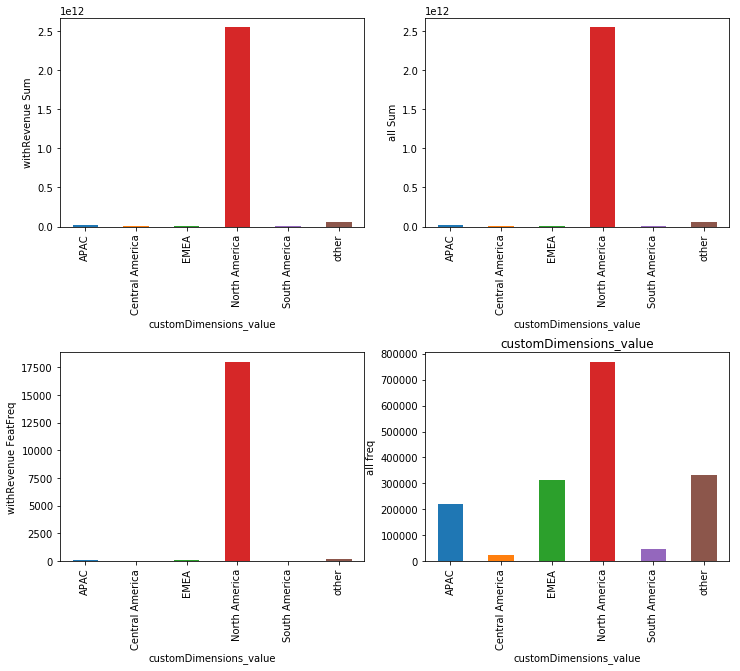

In [25]:
feat_num = 2
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'other')

In [26]:
feat_num = 3
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


to_drop.append(feat)

# cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,'other')

----> Work on feature: date
------> freq > 0.001 feature is:  Index(['20160801', '20160802', '20160803', '20160804', '20160805', '20160808', '20160809', '20160810', '20160811', '20160812',
       ...
       '20180421', '20180422', '20180423', '20180424', '20180425', '20180426', '20180427', '20180428', '20180429', '20180430'], dtype='object', name='date', length=584)
 -----> Unique Feature with Revenue/All: 637 638
====>> Unique: ['20161208' '20170118' '20161020' '20170507' '20171106' '20171204'
 '20170325' '20180225' '20161017' '20161214' '20180122' '20171114'
 '20171017' '20170711' '20170810' '20170707' '20180403' '20170821'
 '20160819' '20170924' '20161221' '20170108' '20180320' '20170823'
 '20161029' '20180207' '20170224' '20170921' '20161011' '20170117'
 '20161206' '20171102' '20170702' '20170106' '20161022' '20160824'
 '20170421' '20161031' '20171015' '20160924' '20170516' '20171107'
 '20160831' '20171007' '20170801' '20170710' '20170807' '20180313'
 '20170719' '20180114' '2017090

----> Work on feature: device.browser
------> freq > 0.001 feature is:  Index(['Android Webview', 'Chrome', 'Edge', 'Firefox', 'Internet Explorer', 'Opera', 'Opera Mini', 'Safari', 'Safari (in-app)', 'Samsung Internet', 'UC Browser', 'YaBrowser', 'other'], dtype='object', name='device.browser')
 -----> Unique Feature with Revenue/All: 11 13
====>> Unique: ['Chrome' 'Opera' 'Safari' 'Firefox' 'Opera Mini' 'Edge' 'other'
 'Internet Explorer' 'YaBrowser' 'UC Browser' 'Safari (in-app)'
 'Android Webview' 'Samsung Internet']
                  type uniqueCount NonPer q01count  q05count  min  max mean
device.browser  object          13      0        0  0.230769  NaN  NaN  NaN
None


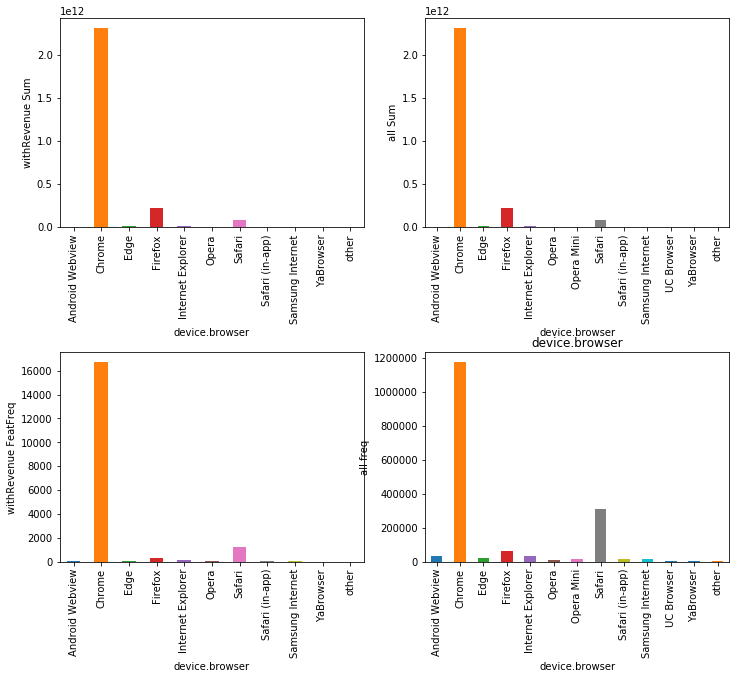

In [29]:
feat_num = 4
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,'other')

In [28]:
def clean_browser(tag):
    common_list = ['Android Webview', 'Chrome', 'Edge', 'Firefox', 'Internet Explorer', 'Opera', 'Opera Mini', 'Safari', 'Safari (in-app)', 'Samsung Internet', 'UC Browser', 'YaBrowser']
    if tag in common_list:
        return tag
    else:
        return 'other'
feat = 'device.browser'
for df in train_df,test_df:
    print("-----> Work on dateframe")
    df[feat] = df[feat].apply(lambda x: clean_browser(x))

-----> Work on dateframe
-----> Work on dateframe


----> Work on feature: device.deviceCategory
------> freq > 0.001 feature is:  Index(['desktop', 'mobile', 'tablet'], dtype='object', name='device.deviceCategory')
 -----> Unique Feature with Revenue/All: 3 3
====>> Unique: ['desktop' 'mobile' 'tablet']
                         type uniqueCount NonPer q01count q05count  min  max mean
device.deviceCategory  object           3      0        0        0  NaN  NaN  NaN
None


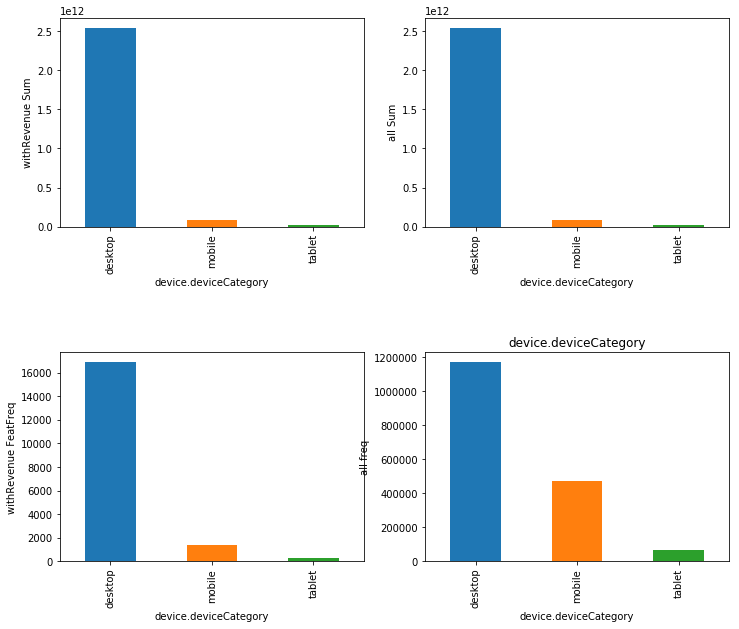

In [30]:
feat_num = 5
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,'other')

----> Work on feature: device.isMobile
------> freq > 0.001 feature is:  Index([False, True], dtype='object', name='device.isMobile')
 -----> Unique Feature with Revenue/All: 2 2
====>> Unique: [False True]
                   type uniqueCount NonPer q01count q05count  min  max mean
device.isMobile  object           2      0        0        0  NaN  NaN  NaN
None


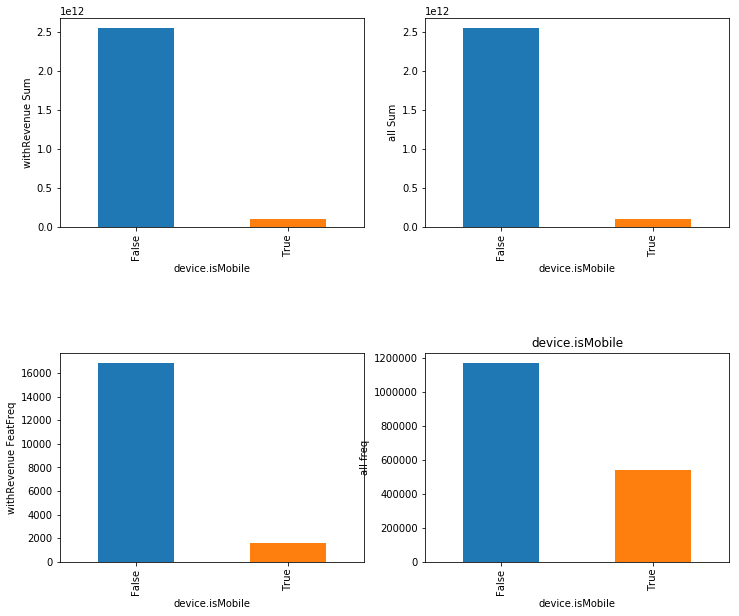

In [31]:
feat_num = 6
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,'other')

----> Work on feature: device.operatingSystem
------> freq > 0.001 feature is:  Index(['(not set)', 'Android', 'Chrome OS', 'Linux', 'Macintosh', 'Windows', 'iOS'], dtype='object', name='device.operatingSystem')
 -----> Unique Feature with Revenue/All: 7 24
====>> Unique: ['Windows' 'Chrome OS' 'Macintosh' 'Android' 'iOS' '(not set)' 'Linux'
 'Windows Phone' 'BlackBerry' 'Nintendo Wii' 'Samsung' 'Firefox OS'
 'Nintendo WiiU' 'OS/2' 'Tizen' 'Xbox' 'FreeBSD' 'Playstation Vita'
 'SunOS' 'Nokia' 'Nintendo 3DS' 'SymbianOS' 'NTT DoCoMo' 'OpenBSD']
                          type uniqueCount NonPer  q01count  q05count  min  max mean
device.operatingSystem  object          24      0  0.708333  0.708333  NaN  NaN  NaN
None


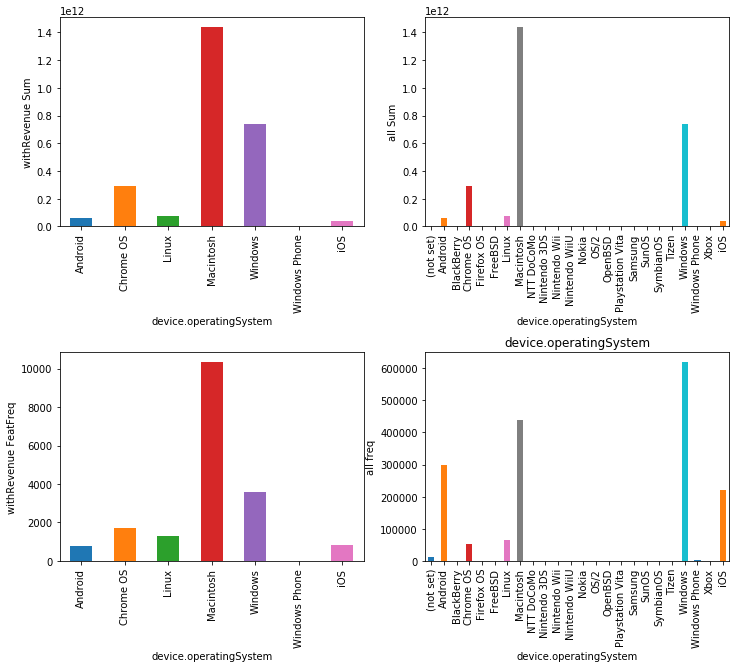

In [32]:
feat_num = 7
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,'other')

In [33]:
feat_num = 8
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
# check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
more_cols.append(feat)
# fill_df_na(feat,'other')

----> Work on feature: fullVisitorId


In [34]:
feat_num = 9
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,'other')

----> Work on feature: geoNetwork.city
------> freq > 0.001 feature is:  Index(['(not set)', 'Ahmedabad', 'Amsterdam', 'Ankara', 'Ann Arbor', 'Atlanta', 'Austin', 'Bangkok', 'Barcelona', 'Bengaluru', 'Berlin', 'Bogota', 'Boston', 'Bucharest', 'Buenos Aires', 'Cairo', 'Cambridge', 'Charlotte', 'Chennai', 'Chicago', 'Dallas', 'Dubai', 'Dublin', 'Fremont', 'Hamburg', 'Hanoi', 'Ho Chi Minh City', 'Hong Kong', 'Houston', 'Hyderabad', 'Irvine', 'Istanbul', 'Jakarta', 'Kirkland', 'Kolkata', 'Kuala Lumpur', 'La Victoria', 'Lagos', 'London', 'Los Angeles', 'Madrid', 'Melbourne', 'Mexico City', 'Milan', 'Minato', 'Montreal', 'Moscow', 'Mountain View', 'Mumbai', 'New Delhi', 'New York', 'Palo Alto', 'Paris', 'Philadelphia', 'Pittsburgh', 'Pune', 'Redmond', 'Salem', 'San Bruno', 'San Diego', 'San Francisco', 'San Jose', 'Santa Clara', 'Sao Paulo', 'Seattle', 'Seoul', 'Singapore', 'Stockholm', 'Sunnyvale', 'Sydney', 'Tel Aviv-Yafo', 'Toronto', 'Warsaw', 'Washington', 'Zurich', 'not available in dem

                   type uniqueCount NonPer  q01count  q05count  min  max mean
geoNetwork.city  object         956      0  0.920502  0.980126  NaN  NaN  NaN
None
Current feature have more then 100 dimensions, break


----> Work on feature: geoNetwork.continent
------> freq > 0.001 feature is:  Index(['(not set)', 'Africa', 'Americas', 'Asia', 'Europe', 'Oceania'], dtype='object', name='geoNetwork.continent')
 -----> Unique Feature with Revenue/All: 6 6
====>> Unique: ['Europe' 'Americas' 'Oceania' 'Asia' 'Africa' '(not set)']
                        type uniqueCount NonPer q01count  q05count  min  max mean
geoNetwork.continent  object           6      0        0  0.166667  NaN  NaN  NaN
None


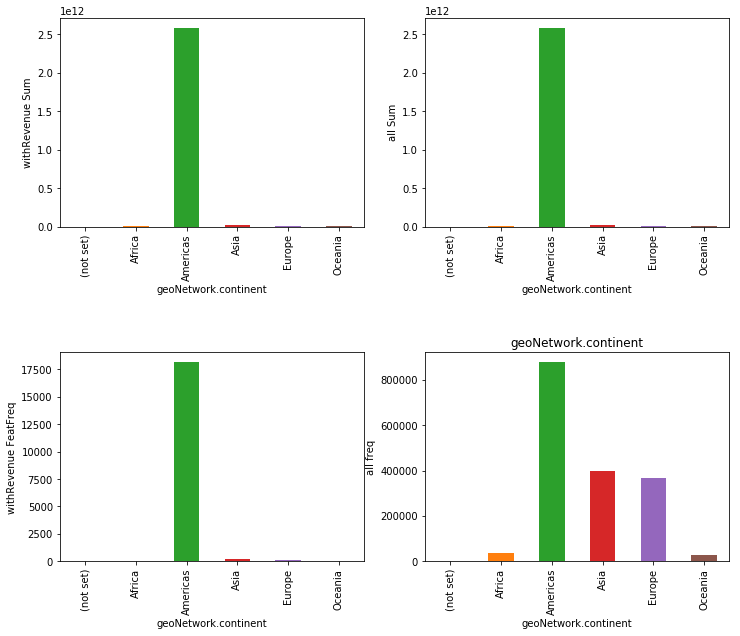

In [35]:
feat_num = 10
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,'other')

----> Work on feature: geoNetwork.country
------> freq > 0.001 feature is:  Index(['(not set)', 'Algeria', 'Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belgium', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'China', 'Colombia', 'Croatia', 'Czechia', 'Denmark', 'Ecuador', 'Egypt', 'Finland', 'France', 'Germany', 'Greece', 'Hong Kong', 'Hungary', 'India', 'Indonesia', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Malaysia', 'Mexico', 'Morocco', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Pakistan', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Saudi Arabia', 'Serbia', 'Singapore', 'Slovakia', 'South Africa', 'South Korea', 'Spain', 'Sri Lanka', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Tunisia', 'Turkey', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'Venezuela', 'Vietnam'], dtype='object', name='geoNetwork.country')
 -----> Unique Feature with Revenue/All: 76 228
====>> Unique: ['Germany' 'Brazil' 'United States' 'Australia

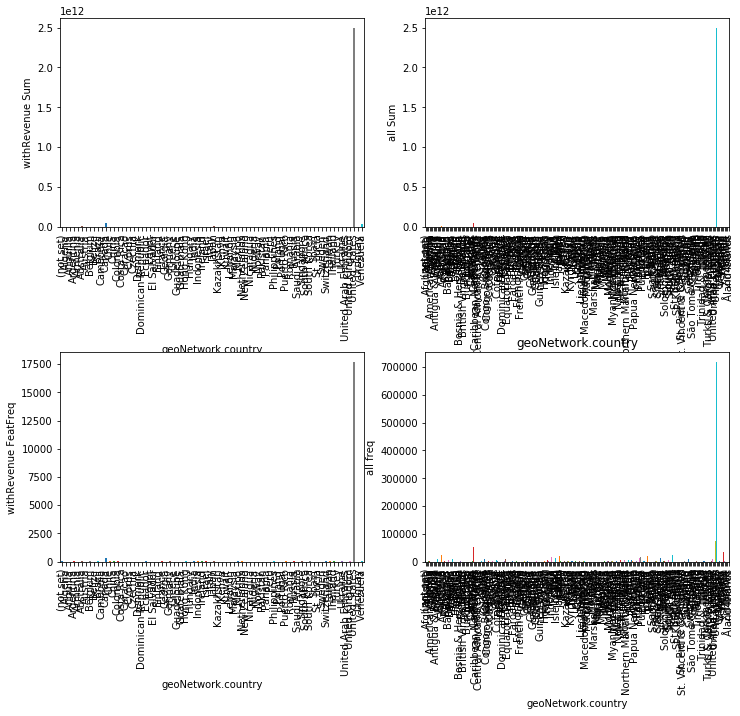

In [36]:
feat_num = 11
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,'other')

----> Work on feature: geoNetwork.metro
------> freq > 0.001 feature is:  Index(['(not set)', 'Atlanta GA', 'Austin TX', 'Boston MA-Manchester NH', 'Charlotte NC', 'Chicago IL', 'Dallas-Ft. Worth TX', 'Denver CO', 'Detroit MI', 'Houston TX', 'JP_KANTO', 'London', 'Los Angeles CA', 'New York NY', 'Philadelphia PA', 'Pittsburgh PA', 'Portland OR', 'Roanoke-Lynchburg VA', 'San Diego CA', 'San Francisco-Oakland-San Jose CA', 'Seattle-Tacoma WA', 'Washington DC (Hagerstown MD)', 'not available in demo dataset'], dtype='object', name='geoNetwork.metro')
 -----> Unique Feature with Revenue/All: 53 123
====>> Unique: ['not available in demo dataset' '(not set)' 'Los Angeles CA' 'London'
 'New York NY' 'San Francisco-Oakland-San Jose CA' 'Seattle-Tacoma WA'
 'Washington DC (Hagerstown MD)' 'Boston MA-Manchester NH' 'Charlotte NC'
 'Atlanta GA' 'San Diego CA' 'Chicago IL' 'Austin TX' 'Houston TX'
 'Detroit MI' 'Pittsburgh PA' 'Portland OR' 'Nashville TN'
 'Dallas-Ft. Worth TX' 'Miami-Ft. Lauderd

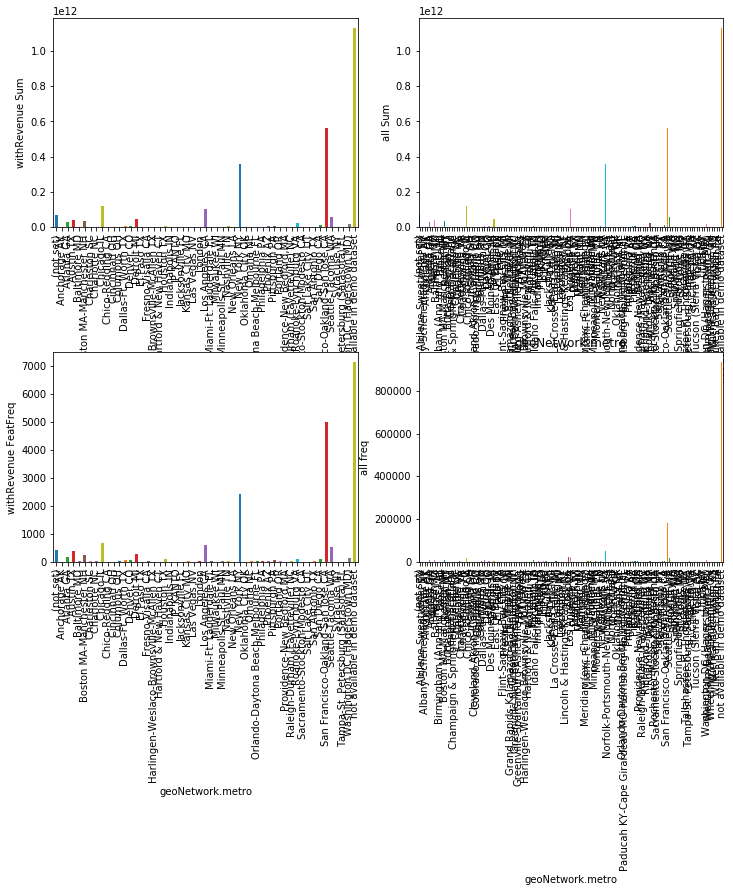

In [37]:
feat_num = 12
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,'other')

In [38]:
feat_num = 13
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
more_cols.append(feat)
# fill_df_na(feat,'other')

----> Work on feature: geoNetwork.networkDomain
------> freq > 0.001 feature is:  Index(['(not set)', '3bb.co.th', 'actcorp.in', 'airtelbroadband.in', 'amazonaws.com', 'as13285.net', 'as9105.com', 'asianet.co.th', 'att.net', 'bbtec.net', 'bell.ca', 'bezeqint.net', 'bhn.net', 'bigpond.net.au', 'btcentralplus.com', 'cable.net.co', 'cantv.net', 'cogentco.com', 'com', 'comcast.net', 'comcastbusiness.net', 'cox.net', 'ctinets.com', 'fastwebnet.it', 'fibertel.com.ar', 'frontiernet.net', 'google.com', 'gvt.net.br', 'hinet.net', 'megared.net.mx', 'mycingular.net', 'myvzw.com', 'netvigator.com', 'ocn.ne.jp', 'ono.com', 'optonline.net', 'optusnet.com.au', 'pldt.net', 'prod-infinitum.com.mx', 'proxad.net', 'qwest.net', 'rcn.com', 'rdsnet.ro', 'rima-tde.net', 'rogers.com', 'rr.com', 'sbcglobal.net', 'sfr.net', 'shawcable.net', 'singnet.com.sg', 'spcsdns.net', 'suddenlink.net', 'superonline.net', 't-ipconnect.de', 'tedata.net', 'telecomitalia.it', 'telefonica.de', 'telesp.net.br', 'telia.com', 'tot

In [39]:
feat_num = 14
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,'other')

----> Work on feature: geoNetwork.region
------> freq > 0.001 feature is:  Index(['(not set)', 'Ankara', 'Bangkok', 'Berlin', 'Bogota', 'Bucharest', 'Buenos Aires', 'Cairo Governorate', 'California', 'Catalonia', 'Colorado', 'Community of Madrid', 'County Dublin', 'Delhi', 'Dhaka Division', 'District of Columbia', 'Dubai', 'England', 'Federal Territory of Kuala Lumpur', 'Florida', 'Georgia', 'Gujarat', 'Hamburg', 'Hanoi', 'Ho Chi Minh', 'Ho Chi Minh City', 'Ile-de-France', 'Illinois', 'Istanbul', 'Jakarta', 'Karnataka', 'Kyiv city', 'Lagos', 'Lima Region', 'Lombardy', 'Madrid', 'Maharashtra', 'Masovian Voivodeship', 'Massachusetts', 'Metro Manila', 'Mexico City', 'Michigan', 'Moscow', 'New South Wales', 'New Taipei City', 'New York', 'North Carolina', 'North Holland', 'Ontario', 'Oregon', 'Pennsylvania', 'Quebec', 'Seoul', 'State of Sao Paulo', 'Stockholm County', 'Taipei City', 'Tamil Nadu', 'Tel Aviv District', 'Telangana', 'Texas', 'Tokyo', 'Victoria', 'Virginia', 'Washington', 'Wes

                     type uniqueCount NonPer  q01count  q05count  min  max mean
geoNetwork.region  object         483      0  0.861284  0.962733  NaN  NaN  NaN
None
Current feature have more then 100 dimensions, break


----> Work on feature: geoNetwork.subContinent
------> freq > 0.001 feature is:  Index(['(not set)', 'Australasia', 'Caribbean', 'Central America', 'Central Asia', 'Eastern Africa', 'Eastern Asia', 'Eastern Europe', 'Northern Africa', 'Northern America', 'Northern Europe', 'South America', 'Southeast Asia', 'Southern Africa', 'Southern Asia', 'Southern Europe', 'Western Africa', 'Western Asia', 'Western Europe'], dtype='object', name='geoNetwork.subContinent')
 -----> Unique Feature with Revenue/All: 19 23
====>> Unique: ['Western Europe' 'South America' 'Northern America' 'Australasia'
 'Eastern Asia' 'Northern Africa' 'Southeast Asia' 'Southern Europe'
 'Northern Europe' 'Eastern Europe' 'Southern Asia' 'Western Asia'
 '(not set)' 'Eastern Africa' 'Caribbean' 'Middle Africa'
 'Central America' 'Western Africa' 'Southern Africa' 'Central Asia'
 'Melanesia' 'Polynesia' 'Micronesian Region']
                           type uniqueCount NonPer  q01count  q05count  min  max mean
geoNetwork

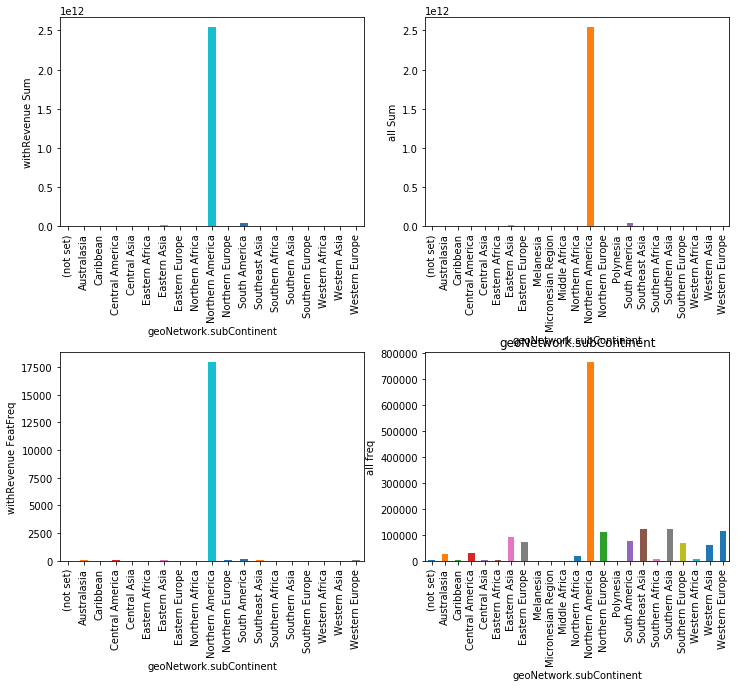

In [40]:
feat_num = 15
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,'other')

In [41]:
feat_num = 16
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
more_cols.append(feat)
# fill_df_na(feat,'other')

----> Work on feature: hits_appInfo.exitScreenName
------> freq > 0.001 feature is:  Index(['shop.googlemerchandisestore.com/asearch.html', 'shop.googlemerchandisestore.com/basket.html', 'shop.googlemerchandisestore.com/google+redesign/accessories', 'shop.googlemerchandisestore.com/google+redesign/accessories/fun', 'shop.googlemerchandisestore.com/google+redesign/accessories/housewares', 'shop.googlemerchandisestore.com/google+redesign/accessories/pet', 'shop.googlemerchandisestore.com/google+redesign/accessories/sports++fitness', 'shop.googlemerchandisestore.com/google+redesign/accessories/stickers/home', 'shop.googlemerchandisestore.com/google+redesign/apparel', 'shop.googlemerchandisestore.com/google+redesign/apparel/headgear', 'shop.googlemerchandisestore.com/google+redesign/apparel/kids', 'shop.googlemerchandisestore.com/google+redesign/apparel/men++s', 'shop.googlemerchandisestore.com/google+redesign/apparel/men++s/men++s+outerwear', 'shop.googlemerchandisestore.com/google+redesi

In [42]:
feat_num = 17
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
more_cols.append(feat)
# fill_df_na(feat,'other')

----> Work on feature: hits_appInfo.landingScreenName
------> freq > 0.001 feature is:  Index(['shop.googlemerchandisestore.com/asearch.html', 'shop.googlemerchandisestore.com/basket.html', 'shop.googlemerchandisestore.com/google redesign/apparel/mens/mens t shirts', 'shop.googlemerchandisestore.com/google+redesign/accessories', 'shop.googlemerchandisestore.com/google+redesign/accessories/stickers/home', 'shop.googlemerchandisestore.com/google+redesign/apparel', 'shop.googlemerchandisestore.com/google+redesign/apparel/headgear', 'shop.googlemerchandisestore.com/google+redesign/apparel/men++s/men++s+outerwear', 'shop.googlemerchandisestore.com/google+redesign/apparel/men++s/men++s+t+shirts', 'shop.googlemerchandisestore.com/google+redesign/apparel/mens', 'shop.googlemerchandisestore.com/google+redesign/apparel/mens+outerwear/blm+sweatshirt.axd', 'shop.googlemerchandisestore.com/google+redesign/apparel/mens/mens+outerwear', 'shop.googlemerchandisestore.com/google+redesign/apparel/mens/me

----> Work on feature: hits_appInfo.screenDepth
------> freq > 0.001 feature is:  Index([0.0], dtype='object', name='hits_appInfo.screenDepth')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: [0.0 '1']
                            type uniqueCount NonPer q01count q05count  min  max mean
hits_appInfo.screenDepth  object           2      0      0.5      0.5  NaN  NaN  NaN
None


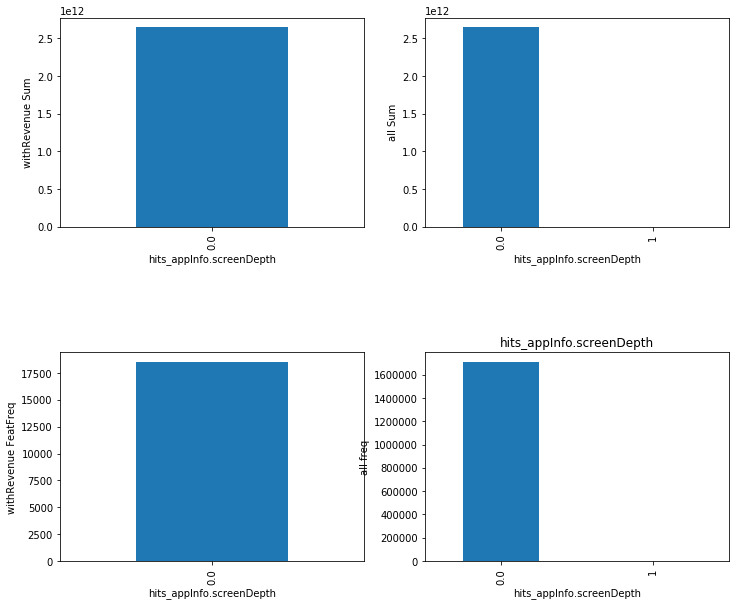

In [47]:
feat_num = 18
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'1')

In [48]:
feat_num = 19
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
more_cols.append(feat)
# fill_df_na(feat,'other')

----> Work on feature: hits_appInfo.screenName
------> freq > 0.001 feature is:  Index(['shop.googlemerchandisestore.com/asearch.html', 'shop.googlemerchandisestore.com/basket.html', 'shop.googlemerchandisestore.com/google redesign/apparel/mens/mens t shirts', 'shop.googlemerchandisestore.com/google+redesign/accessories', 'shop.googlemerchandisestore.com/google+redesign/accessories/stickers/home', 'shop.googlemerchandisestore.com/google+redesign/apparel', 'shop.googlemerchandisestore.com/google+redesign/apparel/headgear', 'shop.googlemerchandisestore.com/google+redesign/apparel/men++s/men++s+outerwear', 'shop.googlemerchandisestore.com/google+redesign/apparel/men++s/men++s+t+shirts', 'shop.googlemerchandisestore.com/google+redesign/apparel/mens', 'shop.googlemerchandisestore.com/google+redesign/apparel/mens+outerwear/blm+sweatshirt.axd', 'shop.googlemerchandisestore.com/google+redesign/apparel/mens/mens+outerwear', 'shop.googlemerchandisestore.com/google+redesign/apparel/mens/mens+t+sh

----> Work on feature: hits_contentGroup.contentGroup1
------> freq > 0.001 feature is:  Index(['(not set)', 'Google'], dtype='object', name='hits_contentGroup.contentGroup1')
 -----> Unique Feature with Revenue/All: 3 5
====>> Unique: ['(not set)' 'other' 'YouTube' 'Google' 'Android']
                                   type uniqueCount NonPer q01count q05count  min  max mean
hits_contentGroup.contentGroup1  object           5      0      0.6      0.8  NaN  NaN  NaN
None


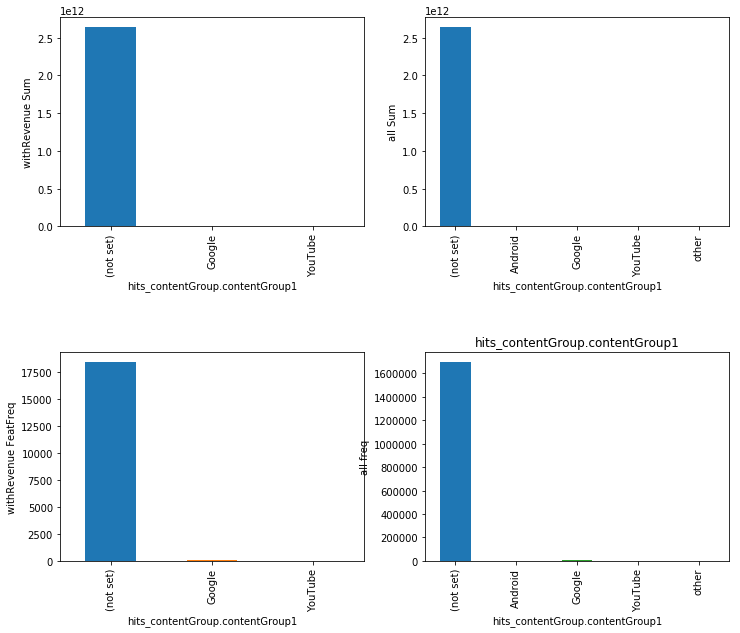

In [50]:
feat_num = 20
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'other')

----> Work on feature: hits_contentGroup.contentGroup2
------> freq > 0.001 feature is:  Index(['(not set)', 'Accessories', 'Apparel', 'Bags', 'Brands', 'Drinkware', 'Electronics', 'Nest', 'Office'], dtype='object', name='hits_contentGroup.contentGroup2')
 -----> Unique Feature with Revenue/All: 10 11
====>> Unique: ['(not set)' 'Brands' 'Apparel' 'Nest' 'other' 'Electronics' 'Bags'
 'Office' 'Drinkware' 'Accessories' 'Lifestyle']
                                   type uniqueCount NonPer  q01count  q05count  min  max mean
hits_contentGroup.contentGroup2  object          11      0  0.181818  0.181818  NaN  NaN  NaN
None


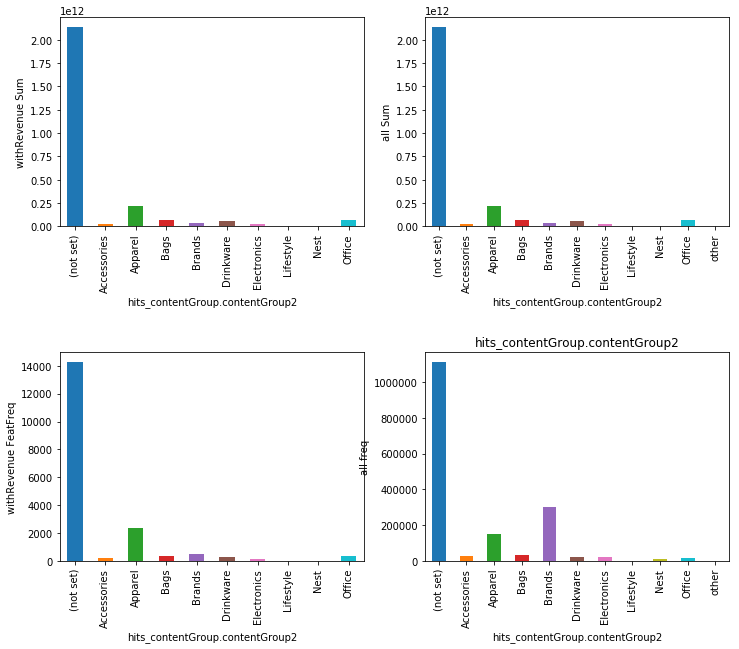

In [52]:
feat_num = 21
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'other')

----> Work on feature: hits_contentGroup.contentGroup3
------> freq > 0.001 feature is:  Index(['(not set)', 'Mens', 'Womens'], dtype='object', name='hits_contentGroup.contentGroup3')
 -----> Unique Feature with Revenue/All: 3 3
====>> Unique: ['(not set)' 'Mens' 'Womens']
                                   type uniqueCount NonPer q01count  q05count  min  max mean
hits_contentGroup.contentGroup3  object           3      0        0  0.333333  NaN  NaN  NaN
None


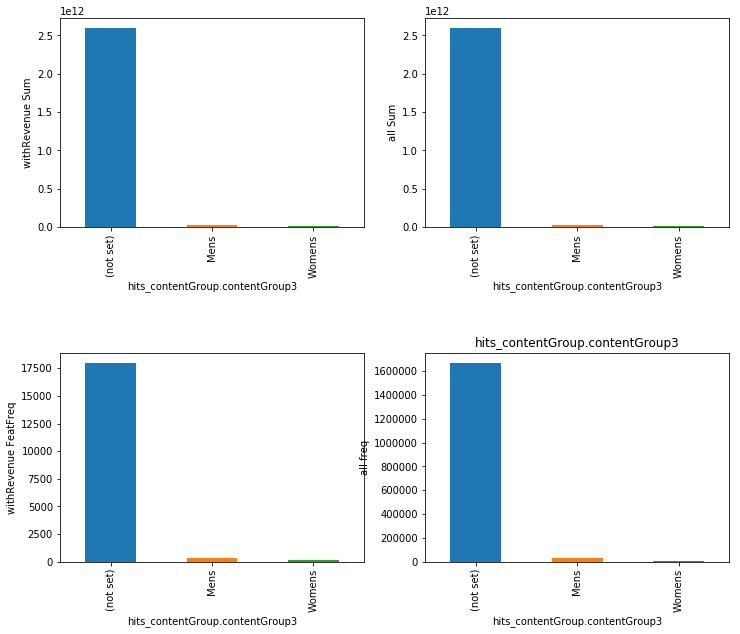

In [54]:
feat_num = 22
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'(not set)')

----> Work on feature: hits_contentGroup.contentGroup4
------> freq > 0.001 feature is:  Index(['(not set)'], dtype='object', name='hits_contentGroup.contentGroup4')
 -----> Unique Feature with Revenue/All: 1 1
====>> Unique: ['(not set)' nan]
                                   type uniqueCount     NonPer q01count q05count  min  max mean
hits_contentGroup.contentGroup4  object           2  0.0711218        0        0  NaN  NaN  NaN
None


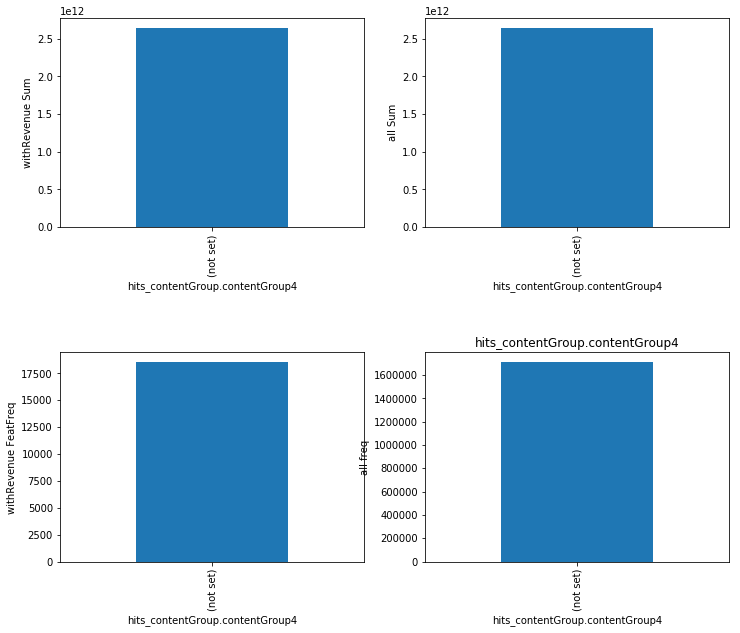

In [55]:
feat_num = 23
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,'other')

----> Work on feature: hits_contentGroup.contentGroup5
------> freq > 0.001 feature is:  Index(['(not set)'], dtype='object', name='hits_contentGroup.contentGroup5')
 -----> Unique Feature with Revenue/All: 1 1
====>> Unique: ['(not set)' nan]
                                   type uniqueCount     NonPer q01count q05count  min  max mean
hits_contentGroup.contentGroup5  object           2  0.0711218        0        0  NaN  NaN  NaN
None


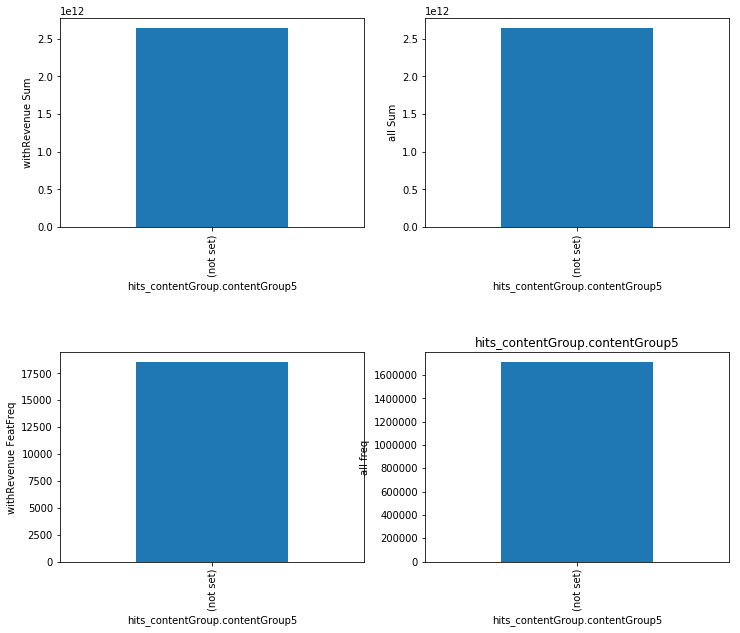

In [57]:
feat_num = 24
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,'other')

----> Work on feature: hits_contentGroup.contentGroupUniqueViews1
------> freq > 0.001 feature is:  Index([1.0, '0'], dtype='object', name='hits_contentGroup.contentGroupUniqueViews1')
 -----> Unique Feature with Revenue/All: 2 2
====>> Unique: ['0' 1.0]
                                              type uniqueCount NonPer q01count q05count  min  max mean
hits_contentGroup.contentGroupUniqueViews1  object           2      0        0      0.5  NaN  NaN  NaN
None


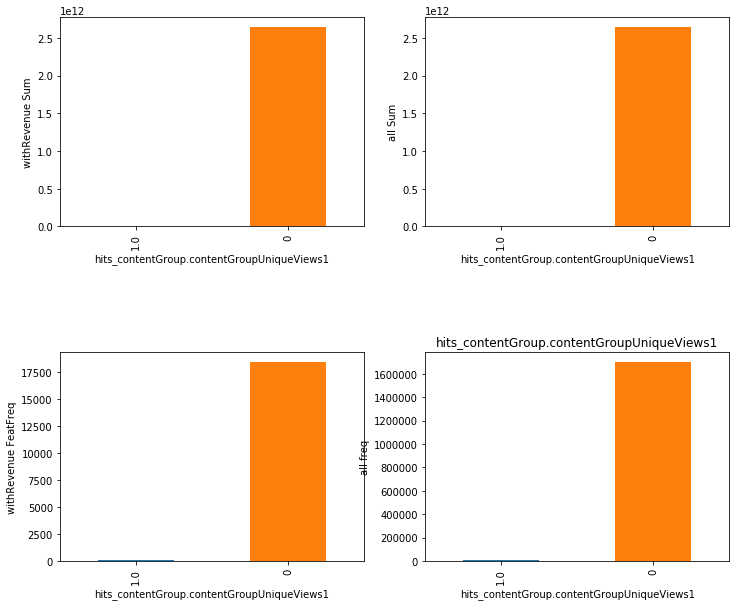

In [59]:
feat_num = 25
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'0')

----> Work on feature: hits_contentGroup.contentGroupUniqueViews2
------> freq > 0.001 feature is:  Index([1.0, '0'], dtype='object', name='hits_contentGroup.contentGroupUniqueViews2')
 -----> Unique Feature with Revenue/All: 2 2
====>> Unique: ['0' 1.0]
                                              type uniqueCount NonPer q01count q05count  min  max mean
hits_contentGroup.contentGroupUniqueViews2  object           2      0        0        0  NaN  NaN  NaN
None


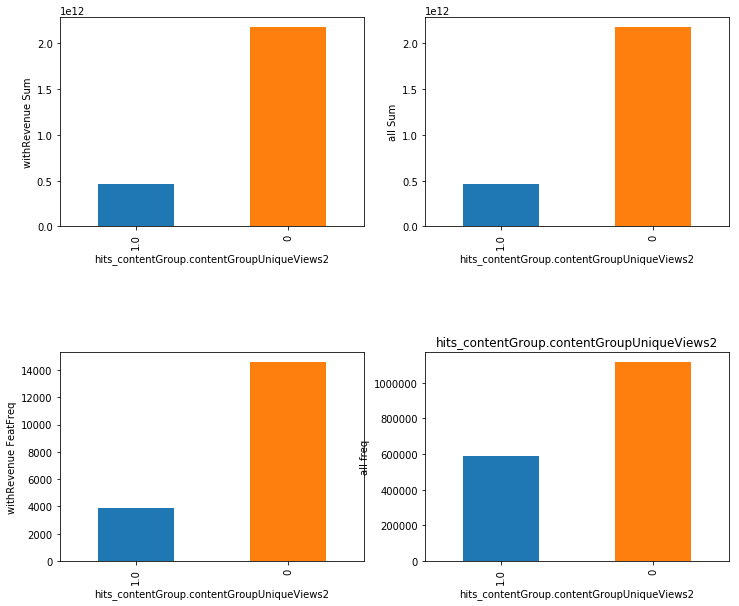

In [61]:
feat_num = 26
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'0')

----> Work on feature: hits_contentGroup.contentGroupUniqueViews3
------> freq > 0.001 feature is:  Index([1.0, '0'], dtype='object', name='hits_contentGroup.contentGroupUniqueViews3')
 -----> Unique Feature with Revenue/All: 2 2
====>> Unique: ['0' 1.0]
                                              type uniqueCount NonPer q01count q05count  min  max mean
hits_contentGroup.contentGroupUniqueViews3  object           2      0        0        0  NaN  NaN  NaN
None


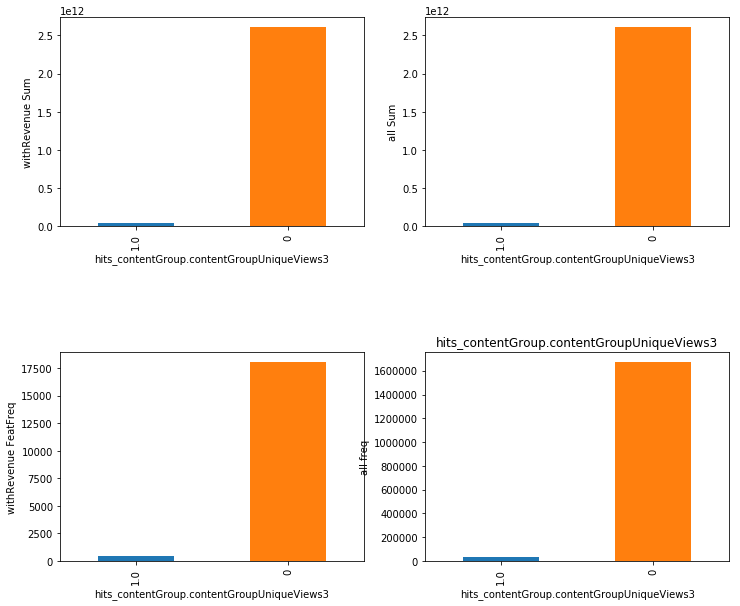

In [63]:
feat_num = 27
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'0')

In [67]:
feat_num = 28
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
# check_me2(feat,train_df)


to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'other')
# train_df.groupby(feat)[target].count()

----> Work on feature: hits_contentGroup.previousContentGroup1


hits_contentGroup.previousContentGroup1
(entrance)    1707122
other            1215
Name: totals.totalTransactionRevenue, dtype: int64

----> Work on feature: hits_contentGroup.previousContentGroup2
------> freq > 0.001 feature is:  Index(['(entrance)'], dtype='object', name='hits_contentGroup.previousContentGroup2')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: ['(entrance)' 'other']
                                           type uniqueCount NonPer q01count q05count  min  max mean
hits_contentGroup.previousContentGroup2  object           2      0      0.5      0.5  NaN  NaN  NaN
None


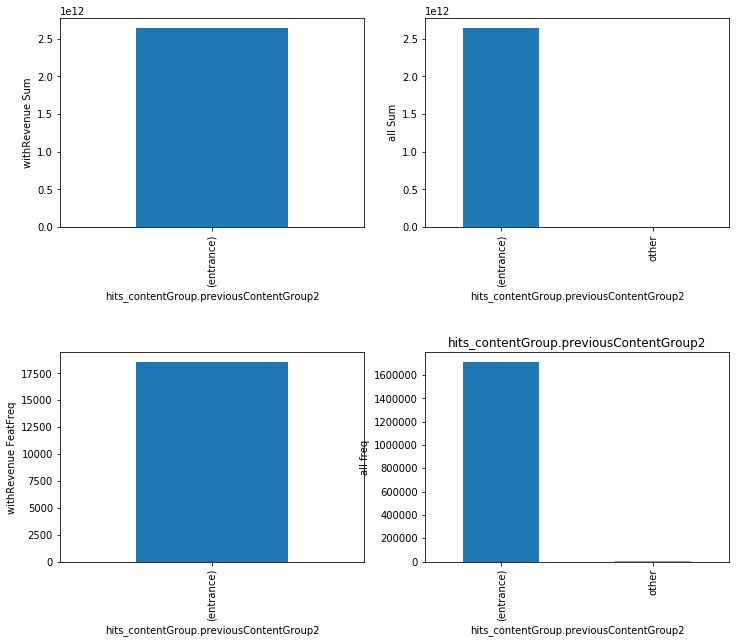

In [69]:
feat_num = 29
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'other')

----> Work on feature: hits_contentGroup.previousContentGroup3
------> freq > 0.001 feature is:  Index(['(entrance)'], dtype='object', name='hits_contentGroup.previousContentGroup3')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: ['(entrance)' 'other']
                                           type uniqueCount NonPer q01count q05count  min  max mean
hits_contentGroup.previousContentGroup3  object           2      0      0.5      0.5  NaN  NaN  NaN
None


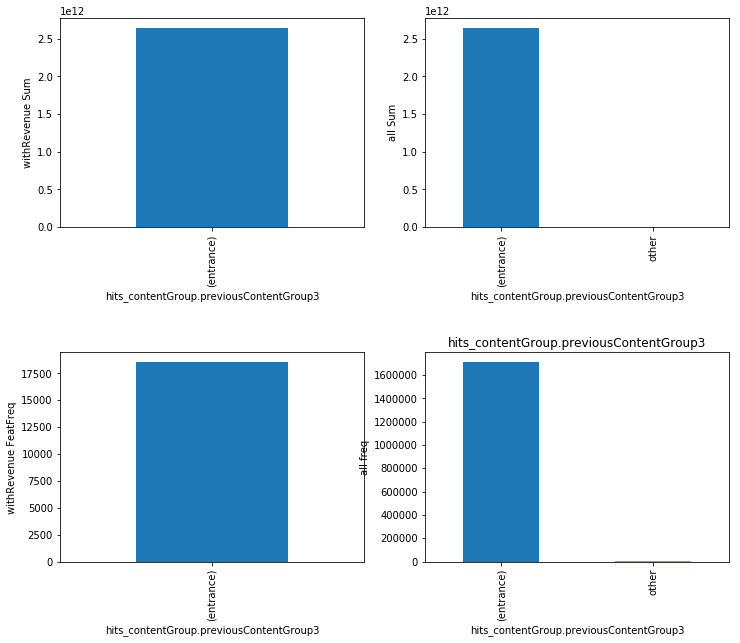

In [71]:
feat_num = 30
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'other')

----> Work on feature: hits_contentGroup.previousContentGroup4
------> freq > 0.001 feature is:  Index(['(entrance)'], dtype='object', name='hits_contentGroup.previousContentGroup4')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: ['(entrance)' 'other']
                                           type uniqueCount NonPer q01count q05count  min  max mean
hits_contentGroup.previousContentGroup4  object           2      0      0.5      0.5  NaN  NaN  NaN
None


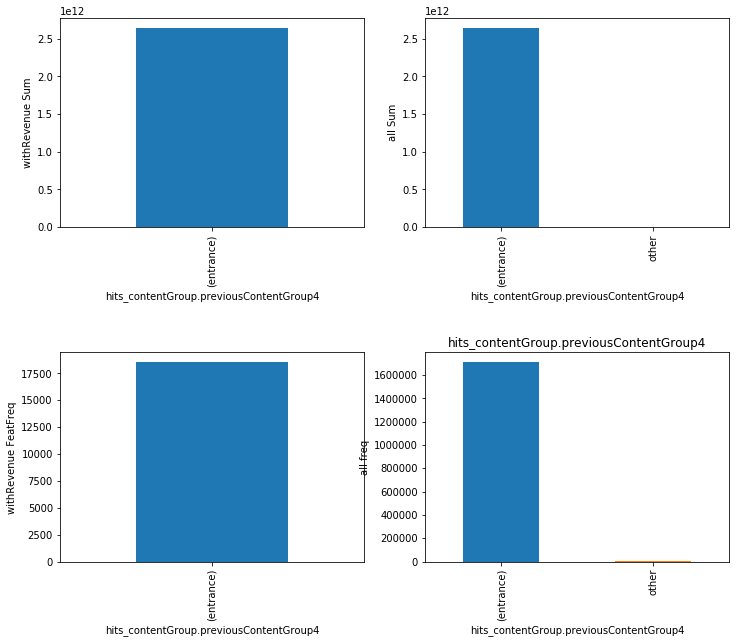

In [73]:
feat_num = 31
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'other')

----> Work on feature: hits_contentGroup.previousContentGroup5
------> freq > 0.001 feature is:  Index(['(entrance)'], dtype='object', name='hits_contentGroup.previousContentGroup5')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: ['(entrance)' 'other']
                                           type uniqueCount NonPer q01count q05count  min  max mean
hits_contentGroup.previousContentGroup5  object           2      0      0.5      0.5  NaN  NaN  NaN
None


hits_contentGroup.previousContentGroup5
(entrance)    2.644108e+12
other         0.000000e+00
Name: totals.totalTransactionRevenue, dtype: float64

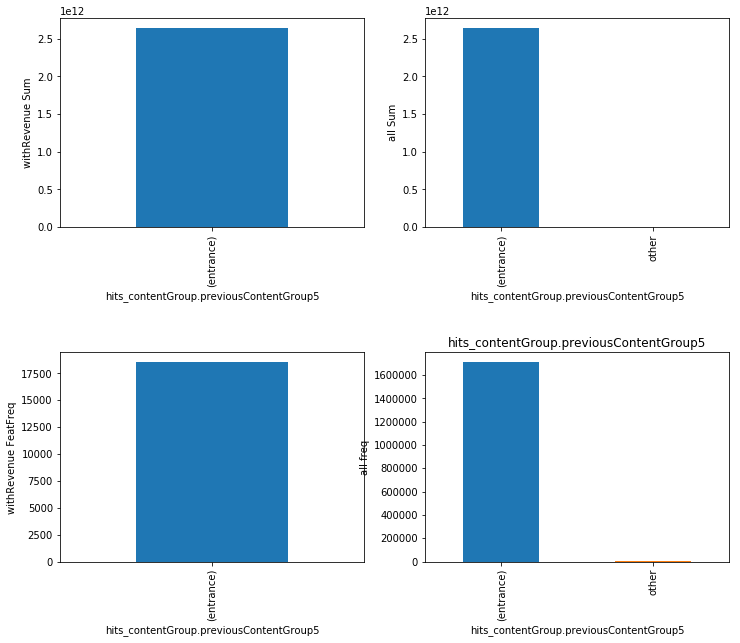

In [77]:
feat_num = 32
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'other')
train_df.groupby(feat)[target].sum()

----> Work on feature: hits_dataSource
------> freq > 0.001 feature is:  Index(['(not set)', 'web'], dtype='object', name='hits_dataSource')
 -----> Unique Feature with Revenue/All: 2 2
====>> Unique: ['(not set)' 'web']
                   type uniqueCount NonPer q01count q05count  min  max mean
hits_dataSource  object           2      0        0        0  NaN  NaN  NaN
None


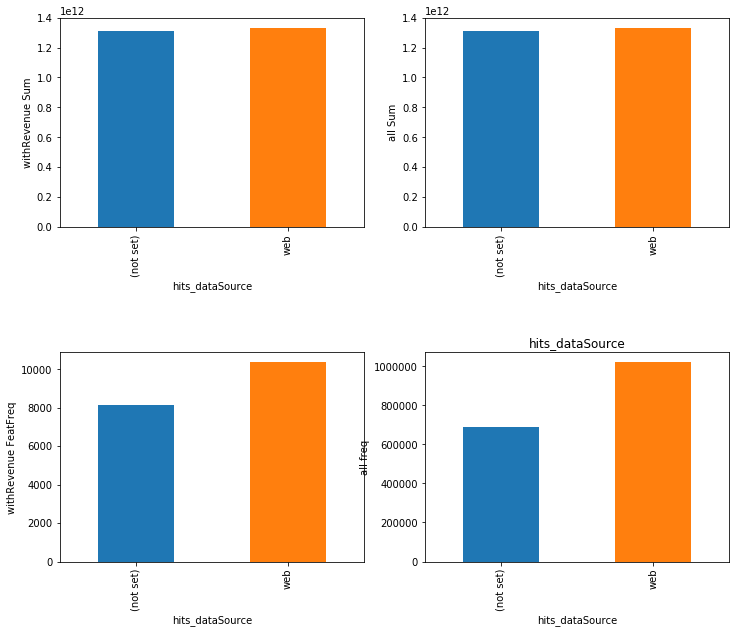

In [79]:
feat_num = 33
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'(not set)')

----> Work on feature: hits_eCommerceAction.action_type
------> freq > 0.001 feature is:  Index([0.0, 1.0, 2.0], dtype='object', name='hits_eCommerceAction.action_type')
 -----> Unique Feature with Revenue/All: 7 8
====>> Unique: [0.0 '7' 1.0 2.0 3.0 4.0 5.0 6.0]
                                    type uniqueCount NonPer q01count q05count  min  max mean
hits_eCommerceAction.action_type  object           8      0    0.625    0.875  NaN  NaN  NaN
None


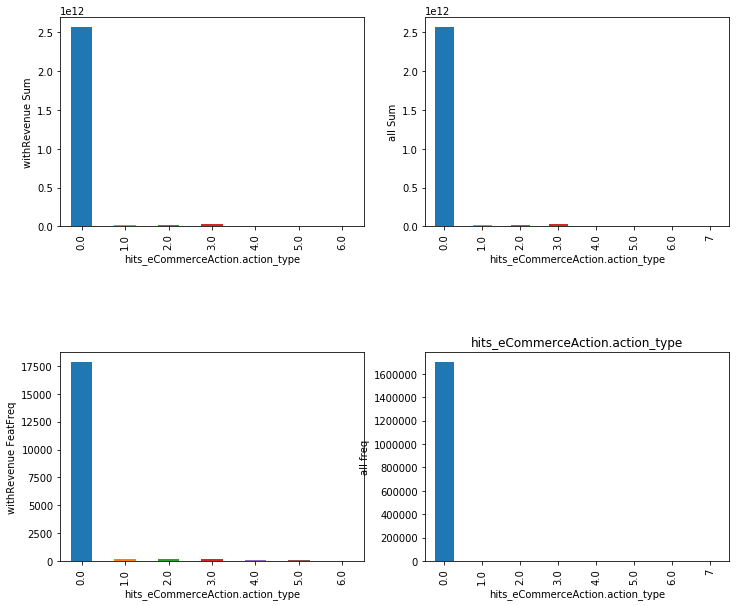

In [81]:
feat_num = 34
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'7')

----> Work on feature: hits_eCommerceAction.option
------> freq > 0.001 feature is:  Index(['other'], dtype='object', name='hits_eCommerceAction.option')
 -----> Unique Feature with Revenue/All: 4 4
====>> Unique: ['other' 'Payment' 'Billing and Shipping' 'Review']
                               type uniqueCount NonPer q01count q05count  min  max mean
hits_eCommerceAction.option  object           4      0     0.75     0.75  NaN  NaN  NaN
None


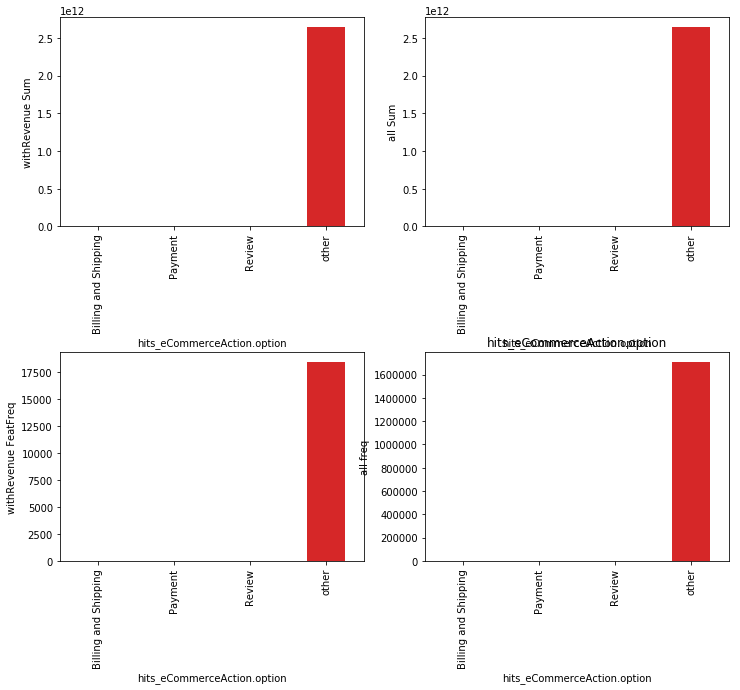

In [83]:
feat_num = 35
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'other')

----> Work on feature: hits_eCommerceAction.step
------> freq > 0.001 feature is:  Index([1.0], dtype='object', name='hits_eCommerceAction.step')
 -----> Unique Feature with Revenue/All: 3 4
====>> Unique: [1.0 '4' 2.0 3.0]
                             type uniqueCount NonPer q01count q05count  min  max mean
hits_eCommerceAction.step  object           4      0     0.75     0.75  NaN  NaN  NaN
None


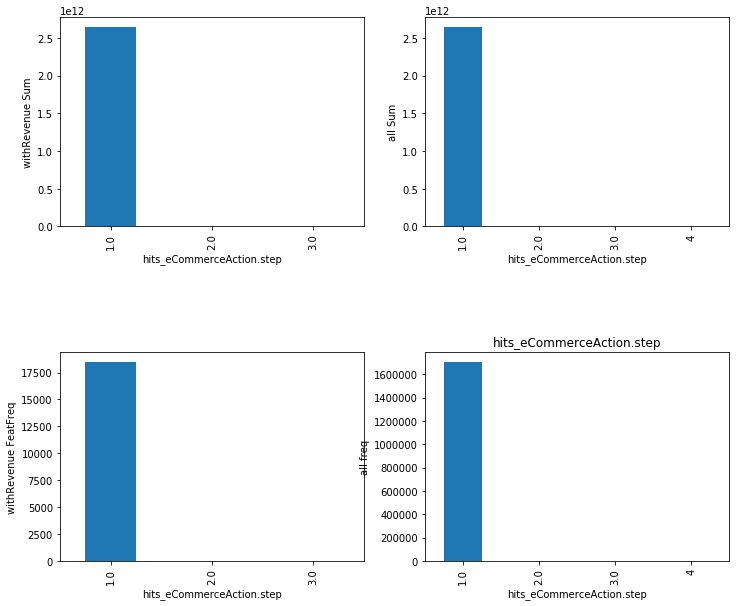

In [85]:
feat_num = 36
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'4')

----> Work on feature: hits_eventInfo.eventAction
------> freq > 0.001 feature is:  Index(['Quickview Click', 'other'], dtype='object', name='hits_eventInfo.eventAction')
 -----> Unique Feature with Revenue/All: 7 7
====>> Unique: ['other' 'Quickview Click' 'Promotion Click' 'Add to Cart' 'Onsite Click'
 'Remove from Cart' 'Product Click']
                              type uniqueCount NonPer  q01count  q05count  min  max mean
hits_eventInfo.eventAction  object           7      0  0.714286  0.857143  NaN  NaN  NaN
None


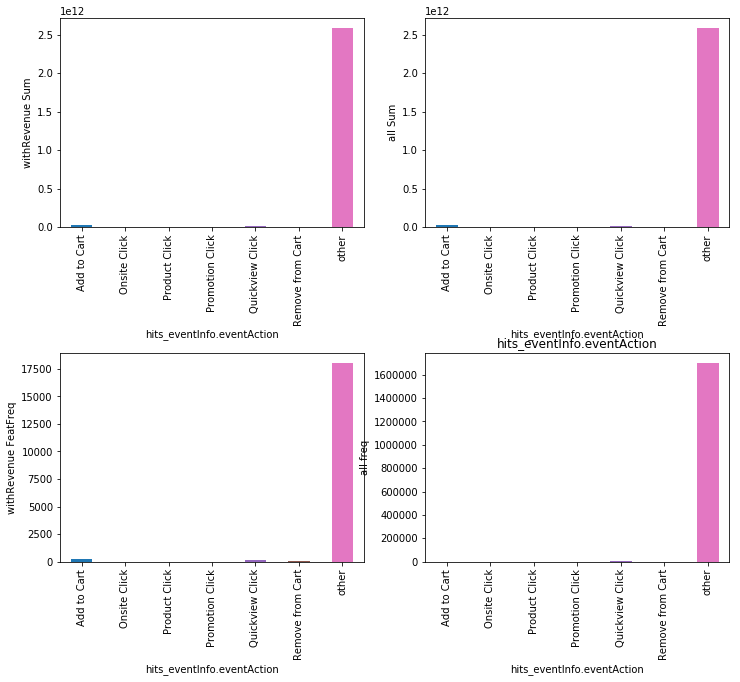

In [87]:
feat_num = 37
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'other')

----> Work on feature: hits_eventInfo.eventCategory
------> freq > 0.001 feature is:  Index(['Enhanced Ecommerce', 'other'], dtype='object', name='hits_eventInfo.eventCategory')
 -----> Unique Feature with Revenue/All: 3 3
====>> Unique: ['other' 'Enhanced Ecommerce' 'Contact Us']
                                type uniqueCount NonPer  q01count  q05count  min  max mean
hits_eventInfo.eventCategory  object           3      0  0.333333  0.666667  NaN  NaN  NaN
None


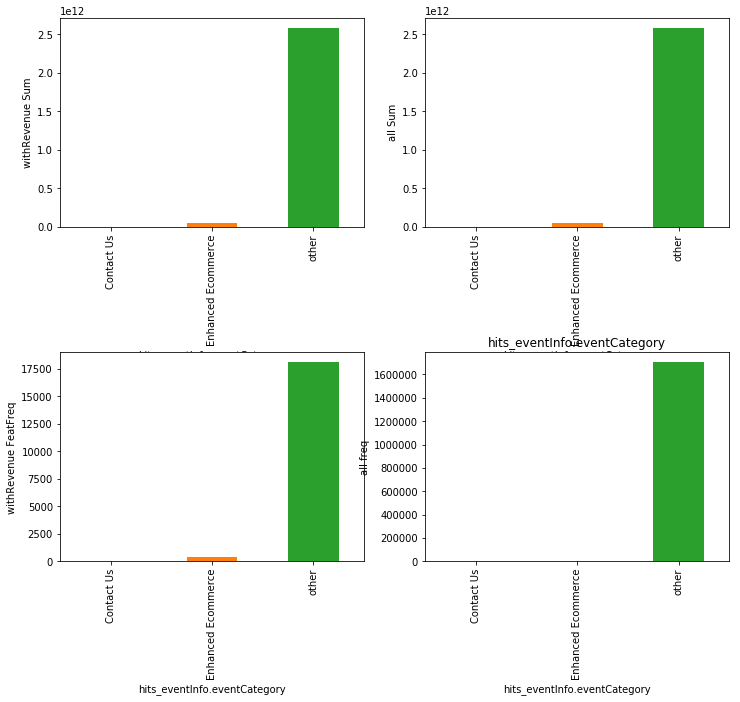

In [89]:
feat_num = 38
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'other')

In [91]:
feat_num = 39
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
# check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
more_cols.append(feat)
fill_df_na(feat,'other')

----> Work on feature: hits_eventInfo.eventLabel


----> Work on feature: hits_exceptionInfo.isFatal
------> freq > 0.001 feature is:  Index([True], dtype='object', name='hits_exceptionInfo.isFatal')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: [ True False]
                            type uniqueCount NonPer q01count q05count  min  max mean
hits_exceptionInfo.isFatal  bool           2      0      0.5      0.5  NaN  NaN  NaN
None


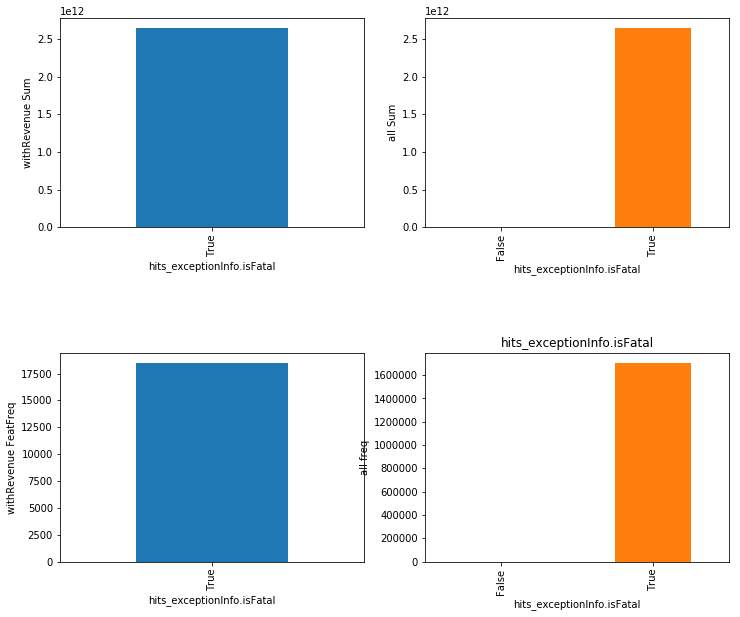

In [94]:
feat_num = 40
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,False)

----> Work on feature: hits_hitNumber
------> freq > 0.001 feature is:  Index([1.0, 2.0], dtype='object', name='hits_hitNumber')
 -----> Unique Feature with Revenue/All: 41 86
====>> Unique: [1.0 2.0 '0' 3.0 7.0 9.0 26.0 13.0 12.0 10.0 11.0 23.0 49.0 14.0 17.0 8.0
 15.0 33.0 4.0 24.0 6.0 56.0 28.0 5.0 46.0 48.0 86.0 19.0 20.0 16.0 34.0
 27.0 31.0 42.0 41.0 18.0 87.0 22.0 32.0 25.0 75.0 39.0 80.0 45.0 21.0
 69.0 108.0 35.0 79.0 50.0 37.0 38.0 40.0 60.0 88.0 43.0 29.0 57.0 51.0
 59.0 63.0 36.0 52.0 58.0 53.0 85.0 72.0 30.0 103.0 95.0 157.0 76.0 44.0
 54.0 62.0 73.0 93.0 55.0 96.0 110.0 114.0 71.0 126.0 61.0 167.0 124.0]
                  type uniqueCount NonPer  q01count  q05count  min  max mean
hits_hitNumber  object          86      0  0.976744  0.988372  NaN  NaN  NaN
None


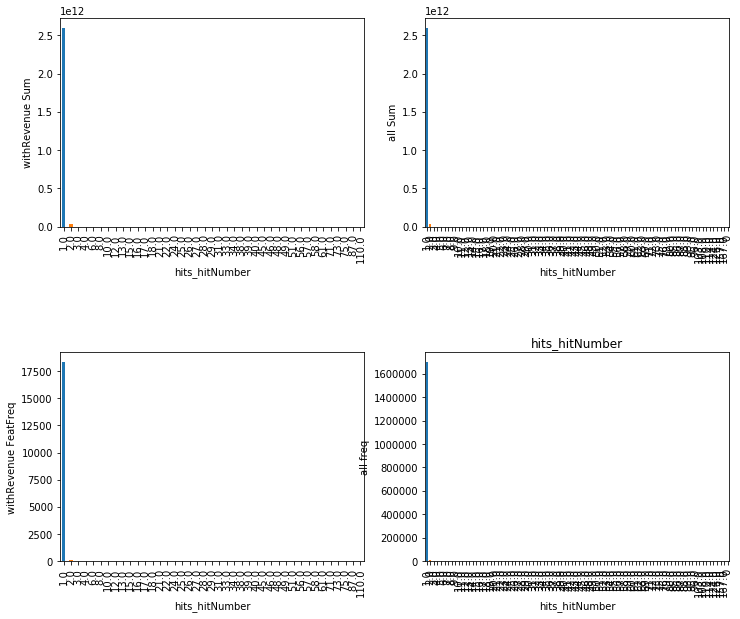

In [109]:
feat_num = 41
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'0')
# train_df.groupby(feat)[feat].count()

----> Work on feature: hits_hour
------> freq > 0.001 feature is:  Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0], dtype='object', name='hits_hour')
 -----> Unique Feature with Revenue/All: 24 25
====>> Unique: [10.0 13.0 20.0 4.0 19.0 6.0 2.0 18.0 0.0 5.0 7.0 12.0 14.0 15.0 3.0 9.0
 16.0 11.0 23.0 8.0 1.0 21.0 17.0 22.0 '24']
             type uniqueCount NonPer q01count q05count  min  max mean
hits_hour  object          25      0     0.04     0.04  NaN  NaN  NaN
None


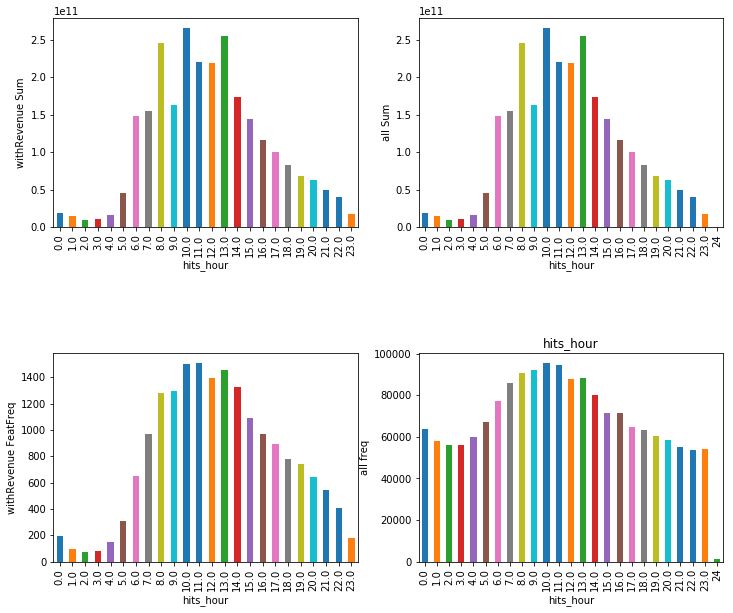

In [112]:
feat_num = 42
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'24')
# train_df.groupby(feat)[feat].count()

----> Work on feature: hits_isEntrance
------> freq > 0.001 feature is:  Index([False, True], dtype='object', name='hits_isEntrance')
 -----> Unique Feature with Revenue/All: 2 2
====>> Unique: [ True False]
                 type uniqueCount NonPer q01count q05count  min  max mean
hits_isEntrance  bool           2      0        0      0.5  NaN  NaN  NaN
None


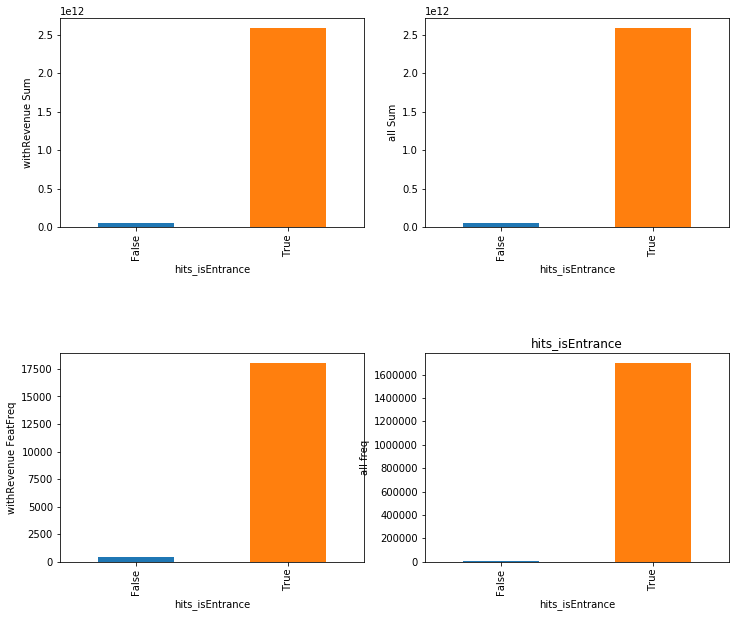

In [116]:
feat_num = 43
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,False)
# train_df.groupby(feat)[feat].count()

----> Work on feature: hits_isExit
------> freq > 0.001 feature is:  Index([False, True], dtype='object', name='hits_isExit')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: [ True False]
             type uniqueCount NonPer q01count q05count  min  max mean
hits_isExit  bool           2      0        0        0  NaN  NaN  NaN
None


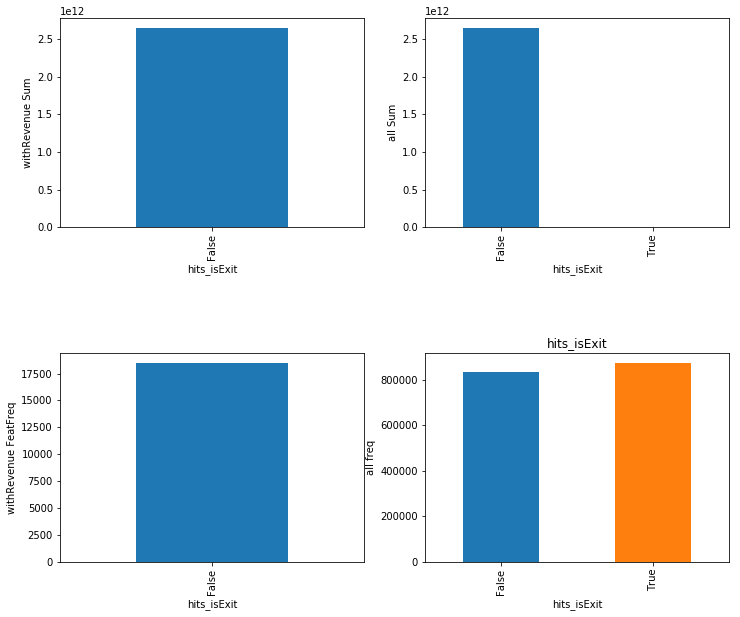

In [125]:

feat_num = 44
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,False)
# train_df.groupby(feat)[feat].count()

----> Work on feature: hits_isInteraction
------> freq > 0.001 feature is:  Index([True], dtype='object', name='hits_isInteraction')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: [ True False]
                    type uniqueCount NonPer q01count q05count  min  max mean
hits_isInteraction  bool           2      0      0.5      0.5  NaN  NaN  NaN
None


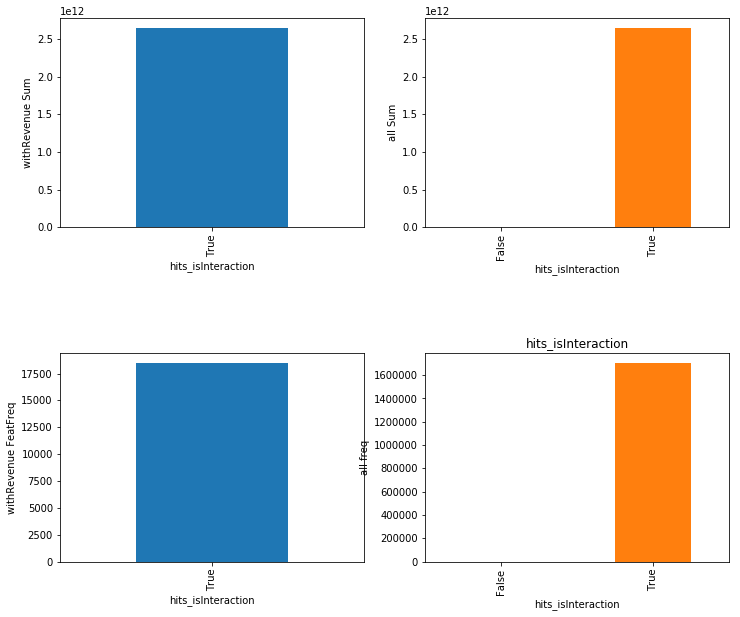

In [129]:
feat_num = 45
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,False)
# train_df.groupby(feat)[feat].count()

----> Work on feature: hits_item.currencyCode
------> freq > 0.001 feature is:  Index(['USD'], dtype='object', name='hits_item.currencyCode')
 -----> Unique Feature with Revenue/All: 1 1
====>> Unique: [nan 'USD']
                          type uniqueCount  NonPer q01count q05count  min  max mean
hits_item.currencyCode  object           2  71.725        0        0  NaN  NaN  NaN
None


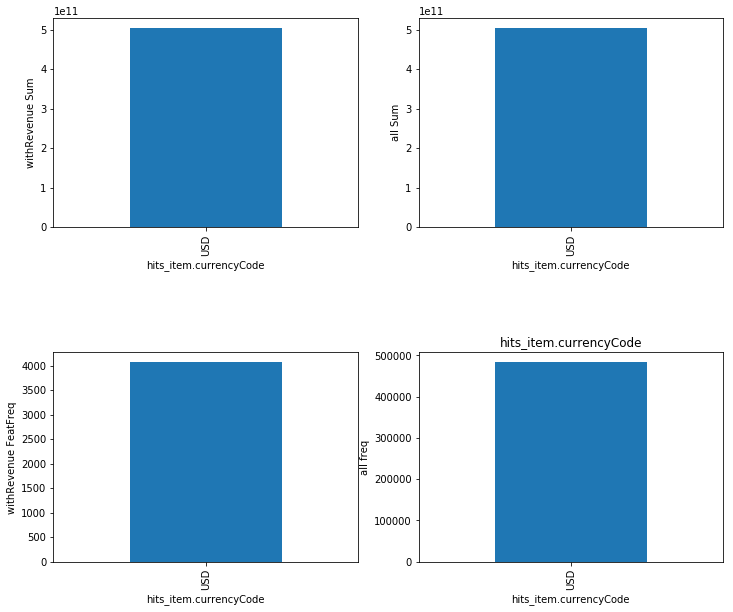

In [131]:
feat_num = 46
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,False)
# train_df.groupby(feat)[feat].count()

----> Work on feature: hits_item.transactionId
------> freq > 0.001 feature is:  Index(['other'], dtype='object', name='hits_item.transactionId')
 -----> Unique Feature with Revenue/All: 11 11
====>> Unique: ['other' 'ORD201711071971' 'ORD201712021370' 'ORD201712031171'
 'ORD201803301578' 'ORD20170422971' 'ORD201611211194' 'ORD201710102886'
 'ORD201702101114' 'ORD201712138312' 'ORD20160909746']
                           type uniqueCount NonPer  q01count  q05count  min  max mean
hits_item.transactionId  object          11      0  0.909091  0.909091  NaN  NaN  NaN
None


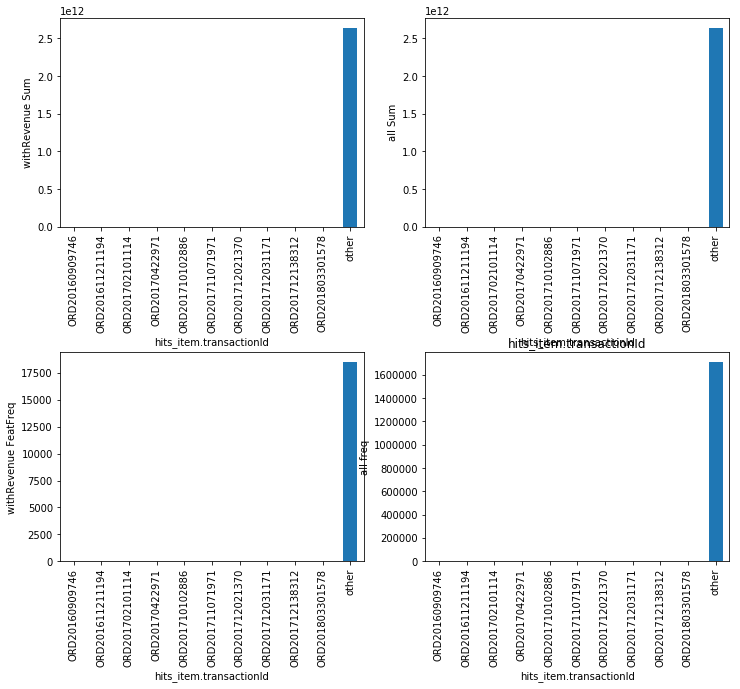

In [135]:
feat_num = 47
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'other')
# train_df.groupby(feat)[feat].count()

In [159]:
# print(len(to_drop))
# to_drop.remove('hits_latencyTracking.domContentLoadedTime')
# print(len(to_drop))

19
18


----> Work on feature: hits_latencyTracking.domContentLoadedTime
------> freq > 0.001 feature is:  Int64Index([0], dtype='int64', name='hits_latencyTracking.domContentLoadedTime')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: [0 1]
                                            type uniqueCount NonPer q01count q05count min max         mean    skewness
hits_latencyTracking.domContentLoadedTime  int64           2      0      0.5      0.5   0   1  5.73657e-05  132.019093
None


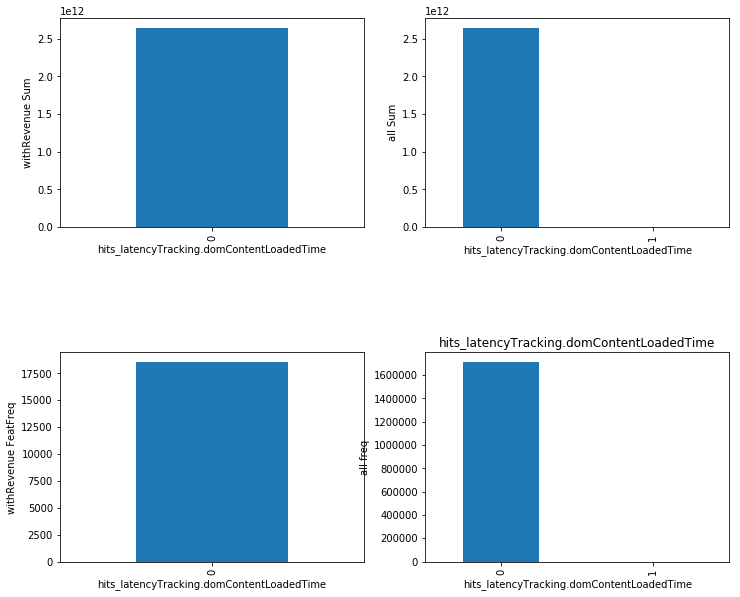

In [162]:
feat_num = 48
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,0)
# train_df.groupby(feat)[target].sum()

In [161]:
feat = 'hits_latencyTracking.domContentLoadedTime'
def clean_domainLookupTime(tag):
    if tag == 0:
        return 0
    else:
        return 1
for df in train_df,test_df:
    print("on dataframe")
    df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

on dataframe
on dataframe


In [158]:
# print(len(to_drop))
# to_drop.remove('hits_latencyTracking.domInteractiveTime')
# print(len(to_drop))

20
19


----> Work on feature: hits_latencyTracking.domInteractiveTime
------> freq > 0.001 feature is:  Int64Index([0], dtype='int64', name='hits_latencyTracking.domInteractiveTime')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: [0 1]
                                          type uniqueCount NonPer q01count q05count min max         mean    skewness
hits_latencyTracking.domInteractiveTime  int64           2      0      0.5      0.5   0   1  5.73657e-05  132.019093
None


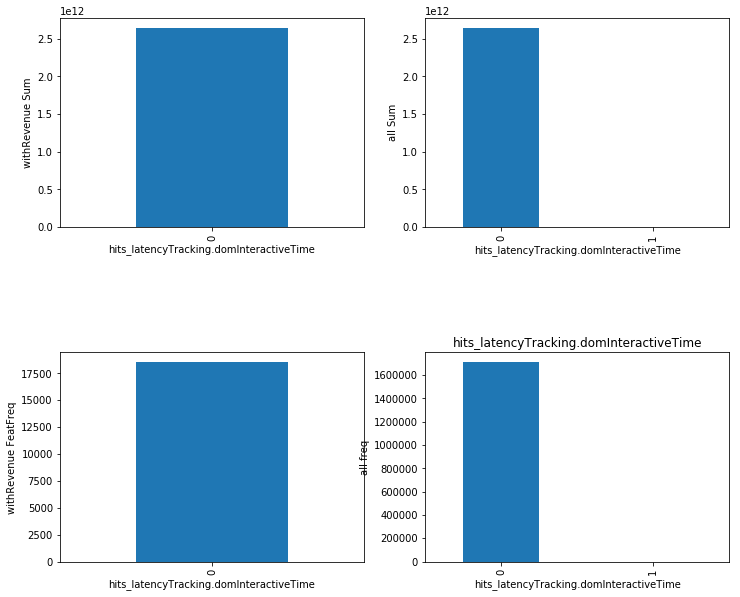

In [165]:
feat_num = 49
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()

In [164]:
feat = 'hits_latencyTracking.domInteractiveTime'
def clean_domainLookupTime(tag):
    if tag == 0:
        return 0
    else:
        return 1
for df in train_df,test_df:
    print("on dataframe")
    df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

on dataframe
on dataframe


----> Work on feature: hits_latencyTracking.domLatencyMetricsSample
------> freq > 0.001 feature is:  Float64Index([0.0], dtype='float64', name='hits_latencyTracking.domLatencyMetricsSample')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: [0. 1.]
                                                 type uniqueCount NonPer q01count q05count min max         mean    skewness
hits_latencyTracking.domLatencyMetricsSample  float64           2      0      0.5      0.5   0   1  5.73657e-05  132.019093
None


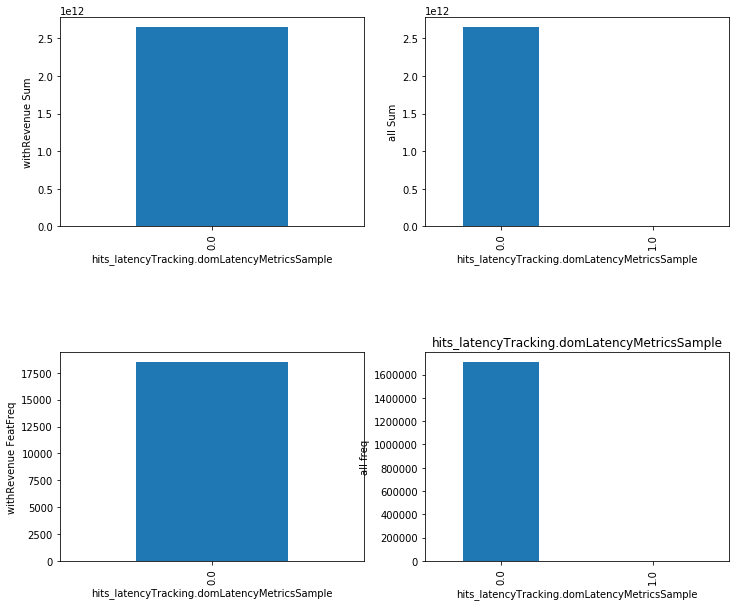

In [150]:
feat_num = 50
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()

----> Work on feature: hits_latencyTracking.domainLookupTime
------> freq > 0.001 feature is:  Int64Index([0], dtype='int64', name='hits_latencyTracking.domainLookupTime')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: [0 1]
                                        type uniqueCount NonPer q01count q05count min max        mean    skewness
hits_latencyTracking.domainLookupTime  int64           2      0      0.5      0.5   0   1  2.5756e-05  197.035299
None


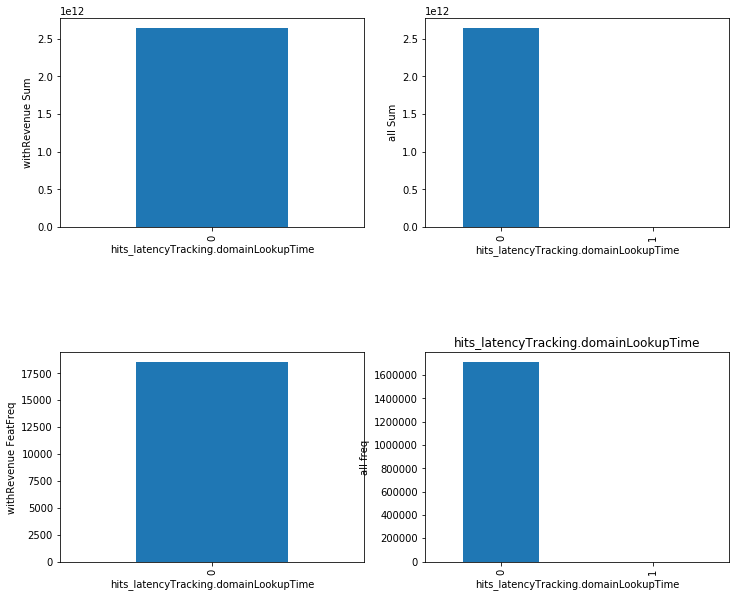

In [156]:
feat_num = 51
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()

In [154]:
def clean_domainLookupTime(tag):
    if tag == 0:
        return 0
    else:
        return 1
for df in train_df,test_df:
    print("on dataframe")
    df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

on dataframe
on dataframe


----> Work on feature: hits_latencyTracking.pageDownloadTime
------> freq > 0.001 feature is:  Int64Index([0], dtype='int64', name='hits_latencyTracking.pageDownloadTime')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: [0 1]
                                        type uniqueCount NonPer q01count q05count min max         mean    skewness
hits_latencyTracking.pageDownloadTime  int64           2      0      0.5      0.5   0   1  5.56096e-05  134.087756
None


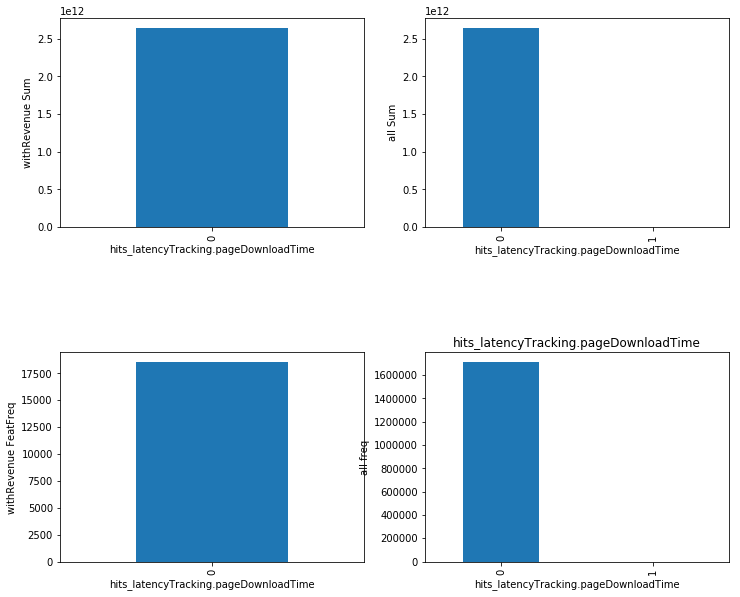

In [171]:
feat_num = 52
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()

In [169]:
feat = 'hits_latencyTracking.pageDownloadTime'
def clean_domainLookupTime(tag):
    if tag == 0:
        return 0
    else:
        return 1
for df in train_df,test_df:
    print("on dataframe")
    df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

on dataframe
on dataframe


----> Work on feature: hits_latencyTracking.pageLoadSample
------> freq > 0.001 feature is:  Float64Index([0.0], dtype='float64', name='hits_latencyTracking.pageLoadSample')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: [0. 1.]
                                        type uniqueCount NonPer q01count q05count min max         mean    skewness
hits_latencyTracking.pageLoadSample  float64           2      0      0.5      0.5   0   1  5.73657e-05  132.019093
None


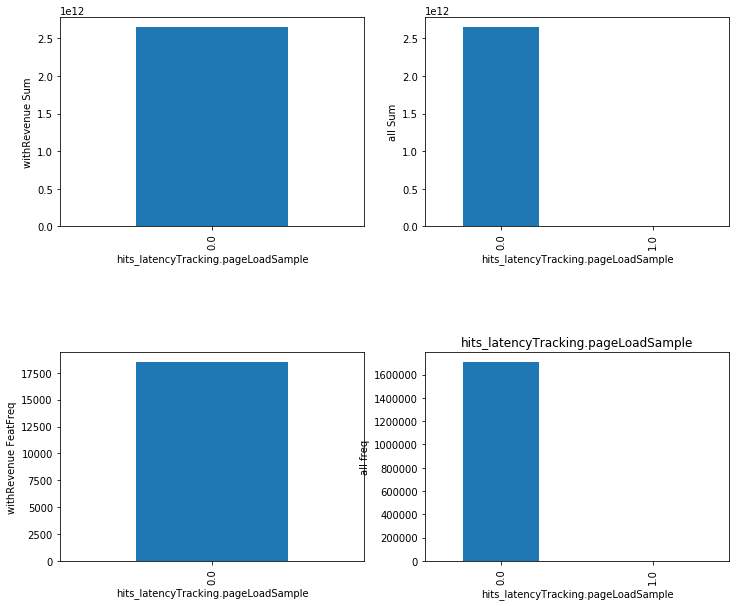

In [175]:
feat_num = 53
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()

----> Work on feature: hits_latencyTracking.pageLoadTime
------> freq > 0.001 feature is:  Int64Index([0], dtype='int64', name='hits_latencyTracking.pageLoadTime')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: [0 1]
                                    type uniqueCount NonPer q01count q05count min max         mean    skewness
hits_latencyTracking.pageLoadTime  int64           2      0      0.5      0.5   0   1  5.73657e-05  132.019093
None
on dataframe
on dataframe


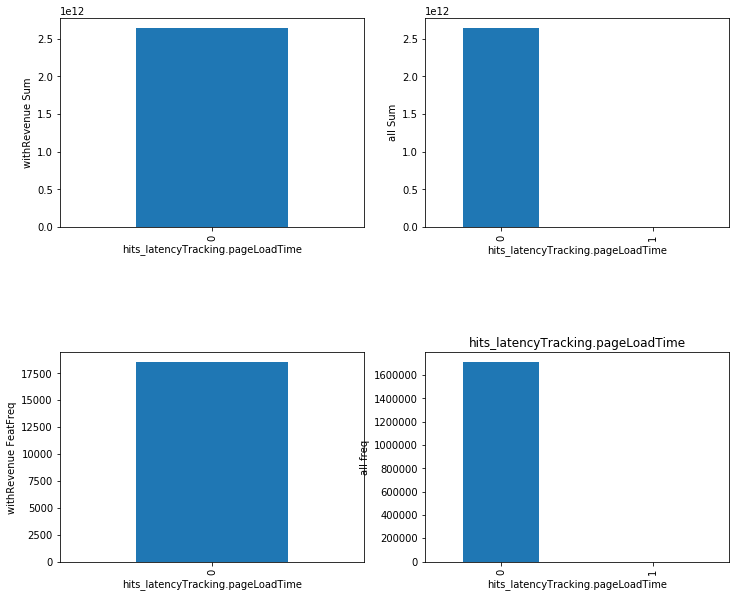

In [181]:
feat_num = 54
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()
def clean_domainLookupTime(tag):
    if tag == 0:
        return 0
    else:
        return 1
for df in train_df,test_df:
    print("on dataframe")
    df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_latencyTracking.redirectionTime
------> freq > 0.001 feature is:  Int64Index([0], dtype='int64', name='hits_latencyTracking.redirectionTime')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: [0 1]
                                       type uniqueCount NonPer q01count q05count min max         mean    skewness
hits_latencyTracking.redirectionTime  int64           2      0      0.5      0.5   0   1  3.27804e-05  174.651285
None
on dataframe
on dataframe


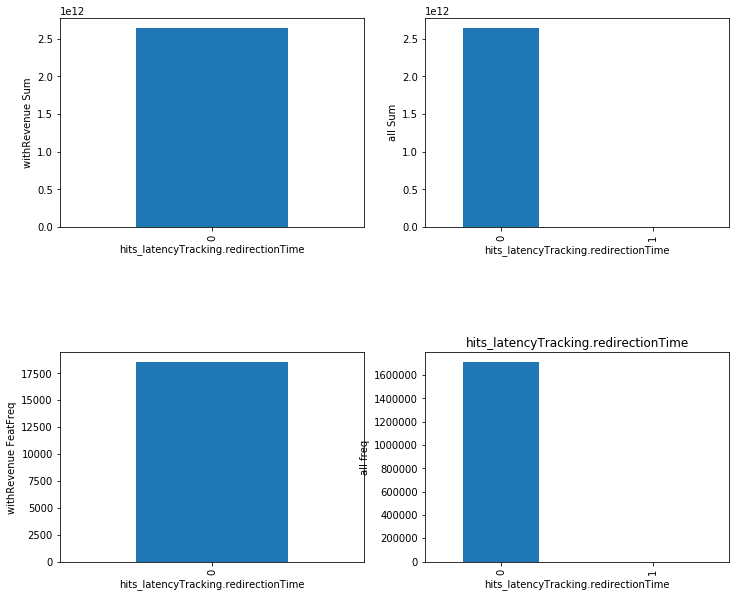

In [187]:
feat_num = 55
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()
def clean_domainLookupTime(tag):
    if tag == 0:
        return 0
    else:
        return 1
for df in train_df,test_df:
    print("on dataframe")
    df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_latencyTracking.serverConnectionTime
------> freq > 0.001 feature is:  Int64Index([0], dtype='int64', name='hits_latencyTracking.serverConnectionTime')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: [0 1]
                                            type uniqueCount NonPer q01count q05count min max         mean    skewness
hits_latencyTracking.serverConnectionTime  int64           2      0      0.5      0.5   0   1  3.27804e-05  174.651285
None
on dataframe
on dataframe


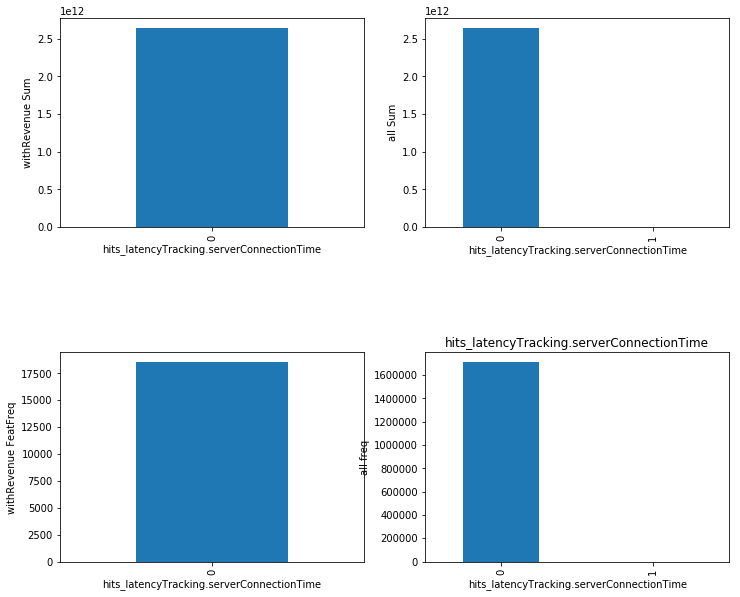

In [202]:
feat_num = 56
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()
def clean_domainLookupTime(tag):
    if tag == 0:
        return 0
    else:
        return 1
for df in train_df,test_df:
    print("on dataframe")
    df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_latencyTracking.serverResponseTime
------> freq > 0.001 feature is:  Int64Index([0], dtype='int64', name='hits_latencyTracking.serverResponseTime')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: [0 1]
                                          type uniqueCount NonPer q01count q05count min max         mean    skewness
hits_latencyTracking.serverResponseTime  int64           2      0      0.5      0.5   0   1  5.20974e-05  138.534586
None
on dataframe
on dataframe


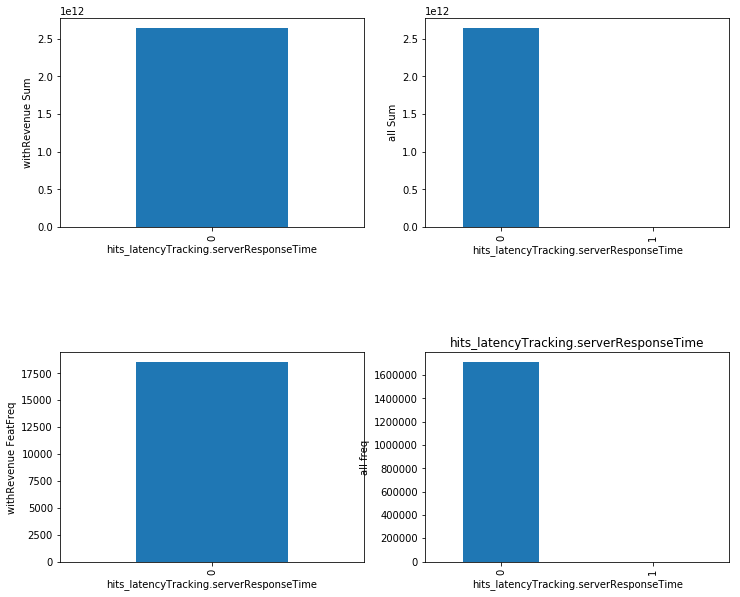

In [201]:
feat_num = 57
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()
def clean_domainLookupTime(tag):
    if tag == 0:
        return 0
    else:
        return 1
for df in train_df,test_df:
    print("on dataframe")
    df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_latencyTracking.speedMetricsSample
------> freq > 0.001 feature is:  Float64Index([0.0], dtype='float64', name='hits_latencyTracking.speedMetricsSample')
 -----> Unique Feature with Revenue/All: 1 2
====>> Unique: [0. 1.]
                                            type uniqueCount NonPer q01count q05count min max         mean    skewness
hits_latencyTracking.speedMetricsSample  float64           2      0      0.5      0.5   0   1  5.73657e-05  132.019093
None


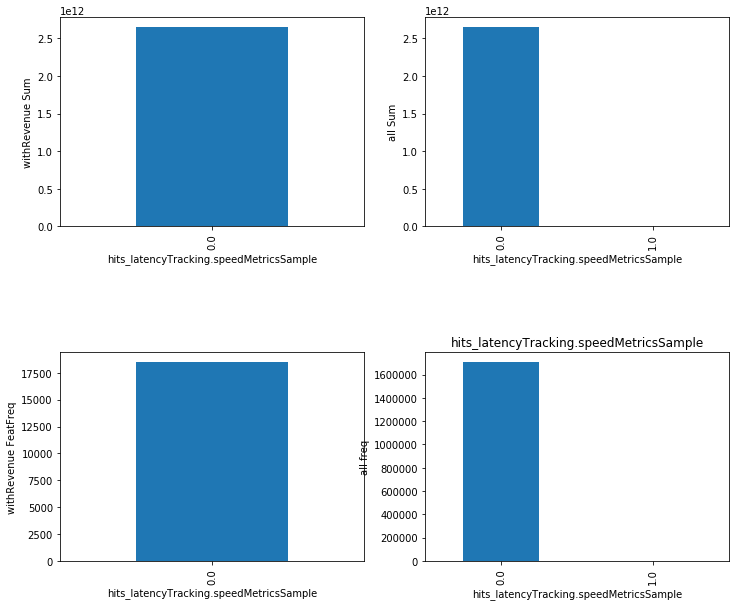

In [204]:
feat_num = 58
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()
# def clean_domainLookupTime(tag):
#     if tag == 0:
#         return 0
#     else:
#         return 1
# for df in train_df,test_df:
#     print("on dataframe")
#     df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_minute
------> freq > 0.001 feature is:  Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0], dtype='float64', name='hits_minute')
 -----> Unique Feature with Revenue/All: 60 61
====>> Unique: [44. 35. 23. 18. 32. 42. 22.  4. 40.  2.  1. 57. 52. 53. 59.  9. 38.  6.
 43. 17. 55.  0. 15. 19. 26. 11. 25. 27. 48. 49. 41. 20. 37. 39. 10. 50.
 13.  5.  8. 56. 34. 14.  7. 46. 58. 54. 12. 51. 24. 30. 45.  3. 29. 36.
 31. 16. 21. 33. 47. 28. 61.]
                type uniqueCount NonPer   q01count   q05count min max     mean  skewness
hits_minute  float64          61      0  0.0163934  0.0163934   0  61  29.5196  -0.00023
None


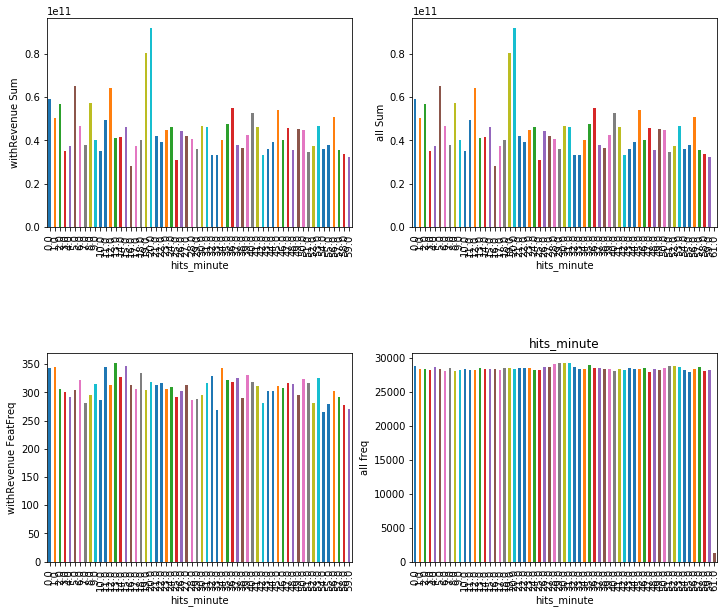

In [208]:
feat_num = 59
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,61)
# train_df.groupby(feat)[feat].count()
# def clean_domainLookupTime(tag):
#     if tag == 0:
#         return 0
#     else:
#         return 1
# for df in train_df,test_df:
#     print("on dataframe")
#     df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_page.hostname
------> freq > 0.001 feature is:  Index(['shop.googlemerchandisestore.com', 'www.googlemerchandisestore.com'], dtype='object', name='hits_page.hostname')
 -----> Unique Feature with Revenue/All: 2 3
====>> Unique: ['www.googlemerchandisestore.com' 'shop.googlemerchandisestore.com'
 'other']
                      type uniqueCount NonPer  q01count  q05count  min  max mean
hits_page.hostname  object           3      0  0.333333  0.333333  NaN  NaN  NaN
None


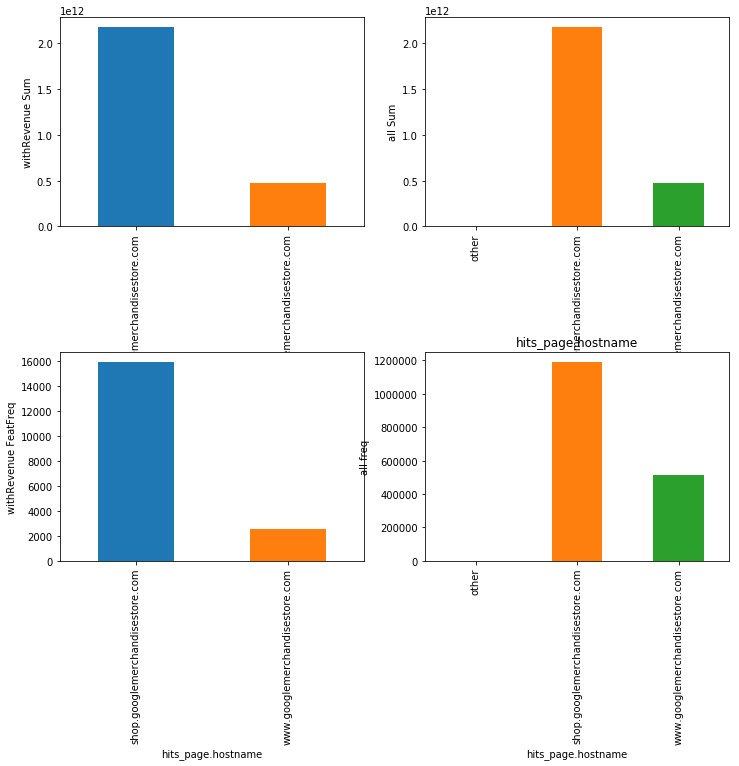

In [212]:
feat_num = 60
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'other')
# train_df.groupby(feat)[feat].count()
# def clean_domainLookupTime(tag):
#     if tag == 0:
#         return 0
#     else:
#         return 1
# for df in train_df,test_df:
#     print("on dataframe")
#     df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

In [214]:
feat_num = 61
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
more_cols.append(feat)
# fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()
# def clean_domainLookupTime(tag):
#     if tag == 0:
#         return 0
#     else:
#         return 1
# for df in train_df,test_df:
#     print("on dataframe")
#     df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_page.pagePath
------> freq > 0.001 feature is:  Index(['/asearch.html', '/basket.html', '/google redesign/apparel/mens/mens t shirts', '/google+redesign/accessories', '/google+redesign/accessories/stickers/home', '/google+redesign/apparel', '/google+redesign/apparel/headgear', '/google+redesign/apparel/men++s/men++s+outerwear', '/google+redesign/apparel/men++s/men++s+t+shirts', '/google+redesign/apparel/mens', '/google+redesign/apparel/mens+outerwear/blm+sweatshirt.axd', '/google+redesign/apparel/mens/mens+outerwear', '/google+redesign/apparel/mens/mens+t+shirts', '/google+redesign/apparel/women+s/women+s+t+shirts', '/google+redesign/apparel/womens', '/google+redesign/apparel/womens/womens+t+shirts', '/google+redesign/bags', '/google+redesign/bags/backpacks/home', '/google+redesign/bags/water+bottles+and+tumblers', '/google+redesign/brands/youtube/home', '/google+redesign/drinkware', '/google+redesign/drinkware/mugs+and+cups', '/google+redesign/electronics',

----> Work on feature: hits_page.pagePathLevel1
------> freq > 0.001 feature is:  Index(['/asearch.html', '/basket.html', '/google redesign/', '/google+redesign/', '/home', '/home-2', '/signin.html', '/store-policies/', '/store.html'], dtype='object', name='hits_page.pagePathLevel1')
 -----> Unique Feature with Revenue/All: 22 51
====>> Unique: ['/home' '/signin.html' '/basket.html' '/store-policies/' '/store.html'
 '/google+redesign/' '/asearch.html/' '/google redesign/' nan '/home-2'
 '/asearch.html' '/register.html' '/storeitem.html'
 '/myaccount.html?mode=vieworderdetail'
 '/myaccount.html?mode=billingaddress' '/shop.axd/'
 '/registersuccess.html' '/myaccount.html?mode=vieworder' '/eco/'
 '/topsellers/' '/payment.html' '/store.html/' '/basket.html+'
 '/yourinfo.html' '/revieworder.html' '/guestregister.html'
 '/ordercompleted.html' '/basket.htmlvid=20160512512' '/basket.html/'
 '/basket.html)' '/myaccount.html?mode=customerinfo' '/payment.html/'
 '/myaccount.html?mode=activities' '

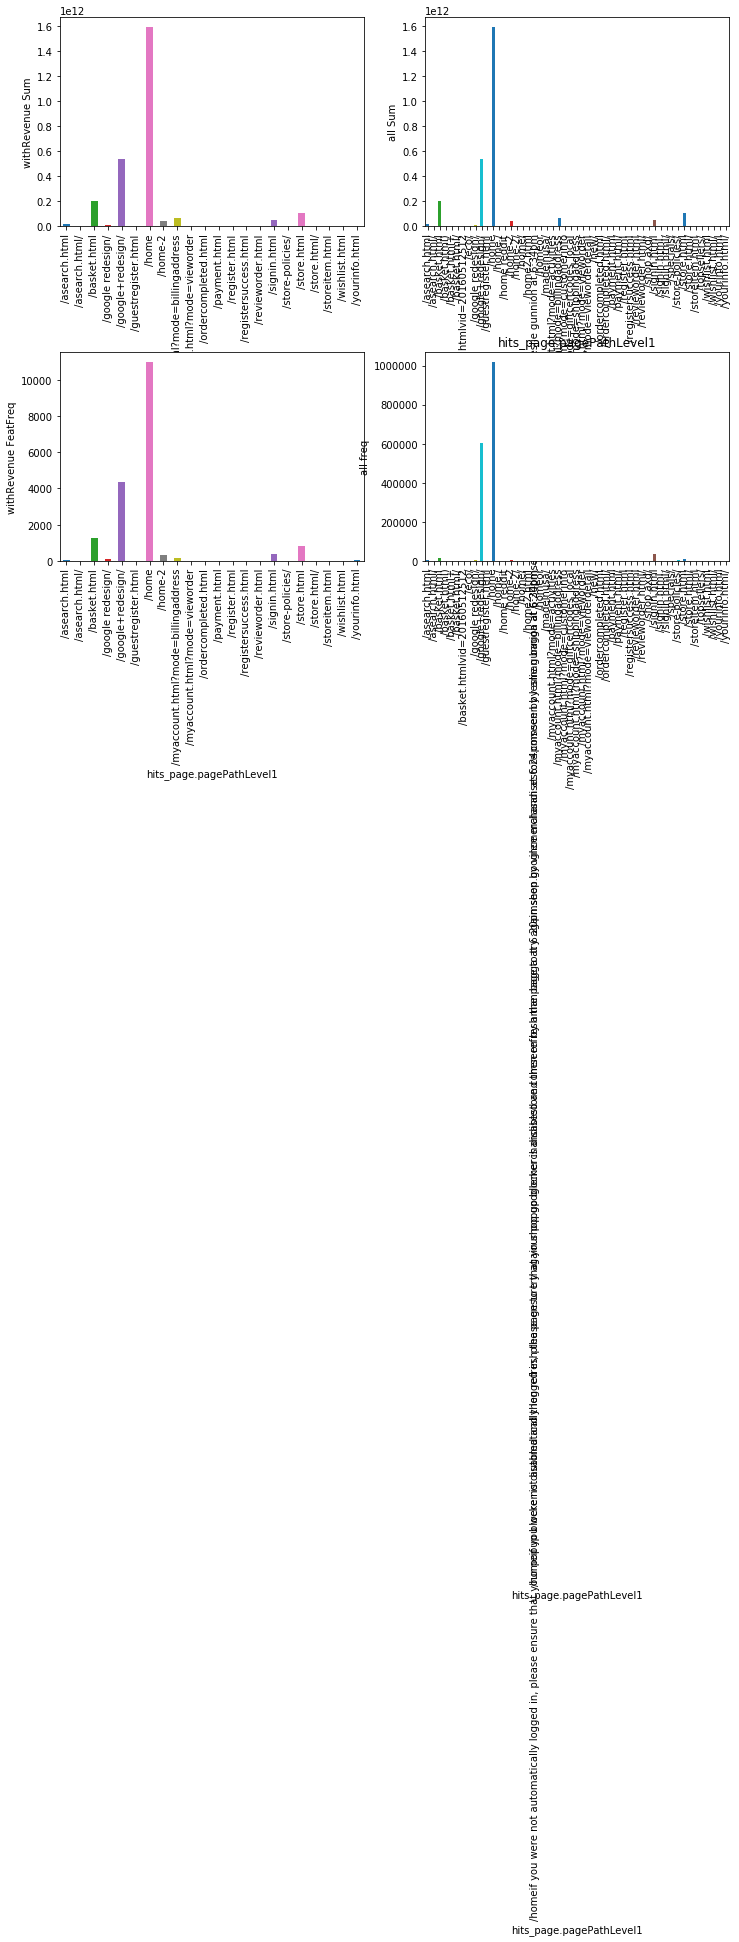

In [216]:
feat_num = 62
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
more_cols.append(feat)
# fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()
# def clean_domainLookupTime(tag):
#     if tag == 0:
#         return 0
#     else:
#         return 1
# for df in train_df,test_df:
#     print("on dataframe")
#     df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_page.pagePathLevel2
------> freq > 0.001 feature is:  Index(['/accessories', '/accessories/', '/apparel', '/apparel/', '/bags', '/bags/', '/brands/', '/drinkware', '/drinkware/', '/electronics', '/electronics/', '/frequently-asked-questions/', '/gift+cards', '/lifestyle/', '/nest/', '/office', '/office/', '/shop+by+brand/'], dtype='object', name='hits_page.pagePathLevel2')
 -----> Unique Feature with Revenue/All: 32 107
====>> Unique: [nan '/shipping-information' '/shop+by+brand/' '/apparel/'
 '/return-policy' '/frequently-asked-questions' '/quickview'
 '/new+2015+logo/' '/brands/' '/nest/' '/electronics/' '/bags/'
 '/electronics' '/office/' '/office' '/apparel' '/drinkware'
 '/accessories' '/drinkware/' '/accessories/' '/lifestyle/' '/bags'
 '/gift+cards' '/shop+by+brand' '/return-policy/' '/electronic/' '/bag/'
 '/cart' '/frequently-asked-questions/' '/wearables/' '/accessories-puppy'
 '/shipping-information/' '/search' '/lifestyle' '/kids/' '/gift+cards/'

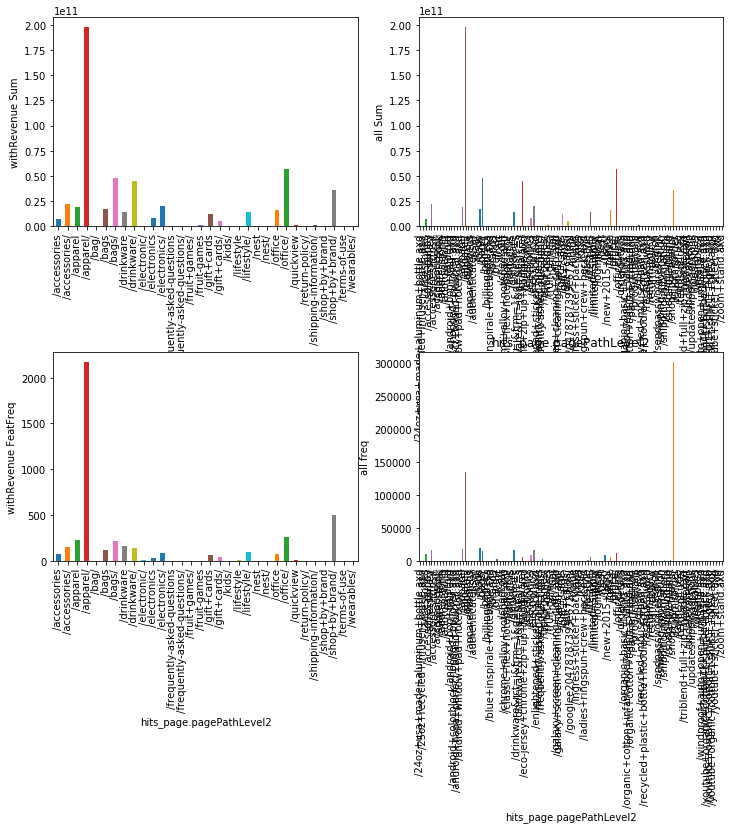

In [218]:
feat_num = 63
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
more_cols.append(feat)
# fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()
# def clean_domainLookupTime(tag):
#     if tag == 0:
#         return 0
#     else:
#         return 1
# for df in train_df,test_df:
#     print("on dataframe")
#     df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

In [220]:
feat_num = 64
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
more_cols.append(feat)
# fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()
# def clean_domainLookupTime(tag):
#     if tag == 0:
#         return 0
#     else:
#         return 1
# for df in train_df,test_df:
#     print("on dataframe")
#     df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_page.pagePathLevel3
------> freq > 0.001 feature is:  Index(['/accessories/', '/android', '/audio', '/audio/', '/backpacks/', '/bottles/', '/fun', '/fun/', '/google', '/headgear', '/home', '/kids/', '/men++s/', '/men+s+t+shirts/', '/mens', '/mens+outerwear/', '/mens+tshirts/', '/mens/', '/mugs+and+cups', '/nest-usa', '/notebooks++journals', '/notebooks+journals/', '/stickers/', '/water+bottles+and+tumblers', '/waze+dress+socks.axd', '/waze/', '/women+s/', '/womens', '/womens/', '/writing/', '/youtube', '/youtube/'], dtype='object', name='hits_page.pagePathLevel3')
 -----> Unique Feature with Revenue/All: 169 411
====>> Unique: [nan '/youtube' '/men++s/' '/wireless+gaming+mouse.axd' '/men s/'
 '/youtube/' '/nest-usa' '/accessories/' '/more+bags' '/android/'
 '/women+s/' '/google+maps/' '/audio' '/notebooks+journals/' '/android'
 '/electronics+accessories' '/backpacks/' '/water+bottles+and+tumblers'
 '/google+device+holder+sticky+pad.axd' '/writing/' '/noteboo

                            type uniqueCount   NonPer  q01count  q05count  min  max mean
hits_page.pagePathLevel3  object         412  69.1053  0.922141  0.987835  NaN  NaN  NaN
None
Current feature have more then 100 dimensions, break


In [223]:
feat_num = 66
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
more_cols.append(feat)
# fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()
# def clean_domainLookupTime(tag):
#     if tag == 0:
#         return 0
#     else:
#         return 1
# for df in train_df,test_df:
#     print("on dataframe")
#     df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_page.pageTitle
------> freq > 0.001 feature is:  Index(['Accessories | Google Merchandise Store', 'Android | Shop by Brand | Google Merchandise Store', 'Apparel | Google Merchandise Store', 'Audio | Electronics | Google Merchandise Store', 'BLM Sweatshirt', 'Backpacks | Bags | Google Merchandise Store', 'Bags | Google Merchandise Store', 'Drinkware', 'Drinkware | Google Merchandise Store', 'Electronics | Google Merchandise Store', 'Frequently Asked Questions', 'Gift Cards | Google Merchandise Store', 'Google Online Store', 'Google | Shop by Brand | Google Merchandise Store', 'Headgear | Apparel | Google Merchandise Store', 'Home', 'Kids' Apparel | Google Merchandise Store', 'Men's Apparel | Google Merchandise Store', 'Men's Outerwear | Apparel | Google Merchandise Store', 'Men's T-Shirts | Apparel | Google Merchandise Store', 'Men's-T-Shirts', 'Mugs & Cups | Drinkware | Google Merchandise Store', 'Nest-USA', 'Notebooks & Journals | Office | Google Merchandis

----> Work on feature: hits_page.searchCategory
------> freq > 0.001 feature is:  Index([], dtype='object', name='hits_page.searchCategory')
 -----> Unique Feature with Revenue/All: 1 1
====>> Unique: [nan '(not set)']
                            type uniqueCount   NonPer q01count q05count  min  max mean
hits_page.searchCategory  object           2  99.9468        1        1  NaN  NaN  NaN
None


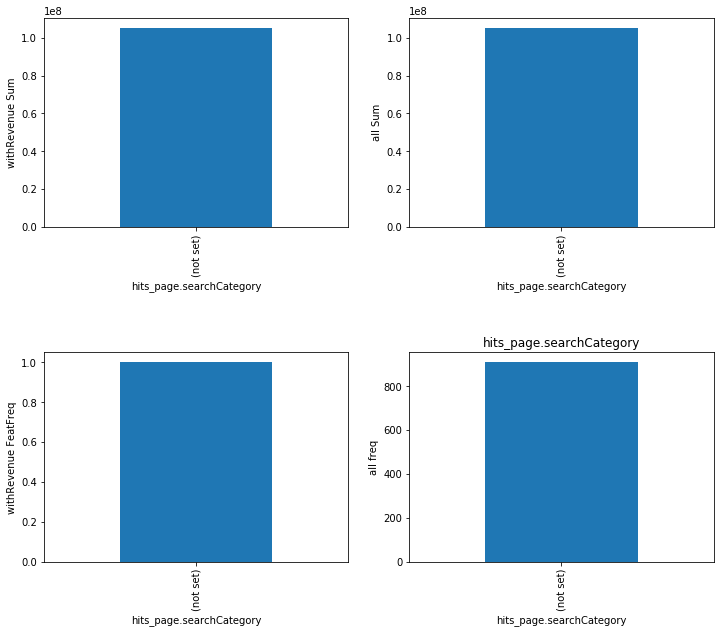

In [225]:
feat_num = 67
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()
# def clean_domainLookupTime(tag):
#     if tag == 0:
#         return 0
#     else:
#         return 1
# for df in train_df,test_df:
#     print("on dataframe")
#     df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_page.searchKeyword
------> freq > 0.001 feature is:  Index(['other'], dtype='object', name='hits_page.searchKeyword')
 -----> Unique Feature with Revenue/All: 2 13
====>> Unique: ['other' 'gopher' 'beanie' 'ingress' 'speakers' 'youtube' 'nexus' 'jersey'
 'pens' 'mug' 'stickers' 'sticker' 'hoodie']
                           type uniqueCount NonPer  q01count  q05count  min  max mean
hits_page.searchKeyword  object          13      0  0.923077  0.923077  NaN  NaN  NaN
None


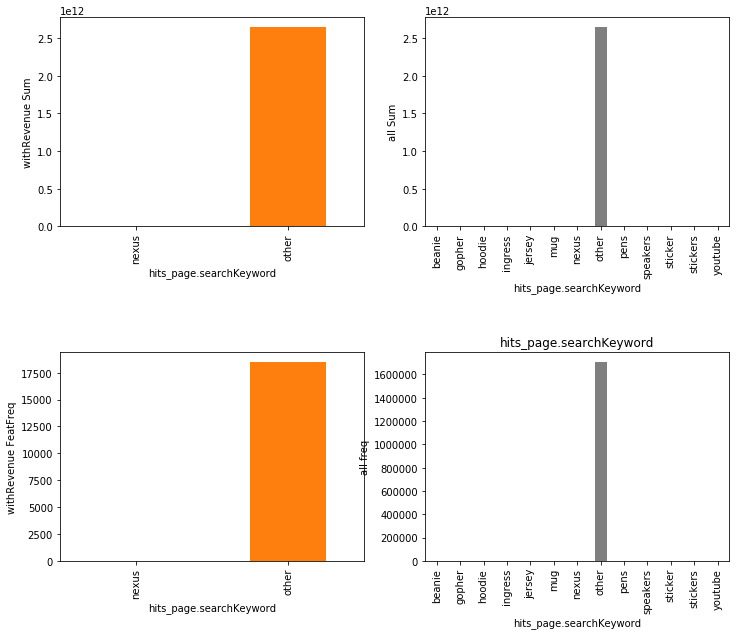

In [229]:
feat_num = 68
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'other')
# train_df.groupby(feat)[feat].count()
# def clean_domainLookupTime(tag):
#     if tag == 0:
#         return 0
#     else:
#         return 1
# for df in train_df,test_df:
#     print("on dataframe")
#     df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_product_isClick
------> freq > 0.001 feature is:  Index([False, True], dtype='object', name='hits_product_isClick')
 -----> Unique Feature with Revenue/All: 2 2
====>> Unique: [False  True]
                      type uniqueCount NonPer q01count q05count  min  max mean
hits_product_isClick  bool           2      0        0      0.5  NaN  NaN  NaN
None


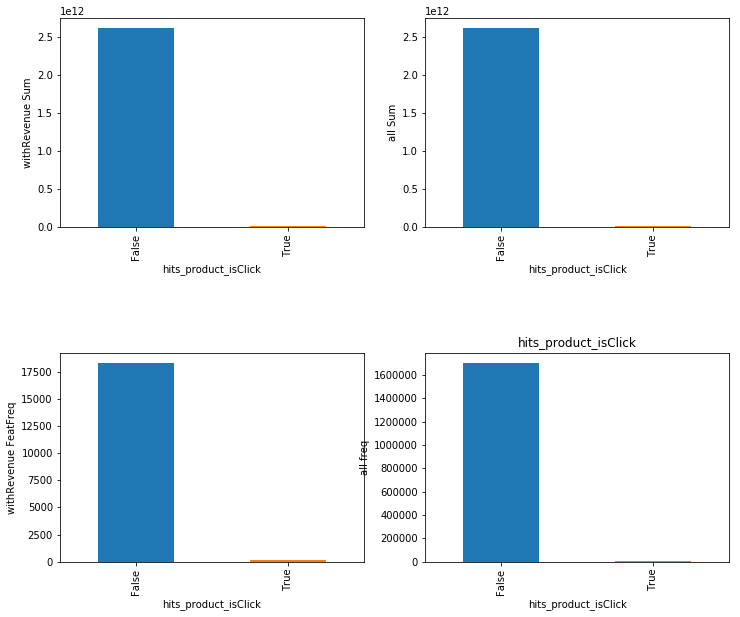

In [233]:
feat_num = 69
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,False)
# train_df.groupby(feat)[feat].count()
# def clean_domainLookupTime(tag):
#     if tag == 0:
#         return 0
#     else:
#         return 1
# for df in train_df,test_df:
#     print("on dataframe")
#     df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_product_isImpression
------> freq > 0.001 feature is:  Index([False, True], dtype='object', name='hits_product_isImpression')
 -----> Unique Feature with Revenue/All: 2 2
====>> Unique: [False  True]
                           type uniqueCount NonPer q01count q05count  min  max mean
hits_product_isImpression  bool           2      0        0        0  NaN  NaN  NaN
None


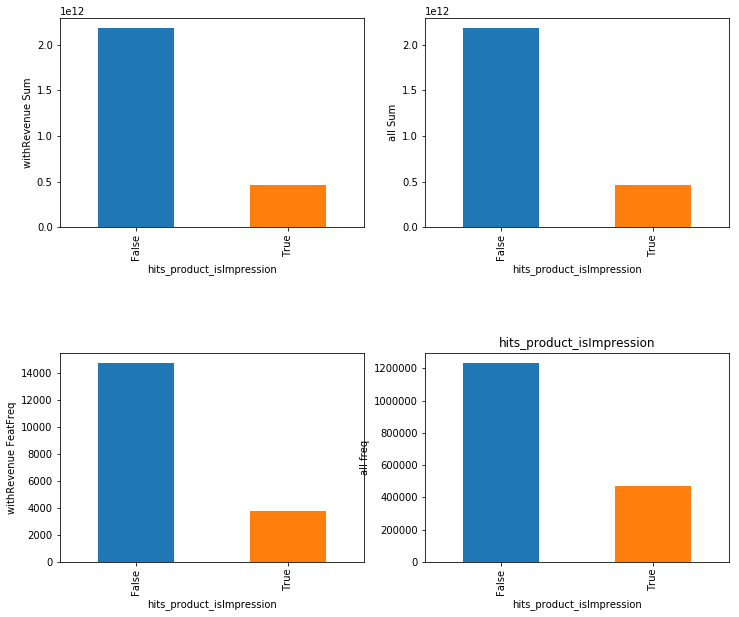

In [237]:
feat_num = 70
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,False)
# train_df.groupby(feat)[feat].count()
# def clean_domainLookupTime(tag):
#     if tag == 0:
#         return 0
#     else:
#         return 1
# for df in train_df,test_df:
#     print("on dataframe")
#     df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_product_localProductPrice
------> freq > 0.001 feature is:  Float64Index([0.0, 1500000.0, 1990000.0, 2990000.0, 3500000.0, 3990000.0, 4990000.0, 7990000.0, 8990000.0, 10990000.0, 11990000.0, 12990000.0, 13990000.0, 15990000.0, 16990000.0, 18990000.0, 19990000.0, 21990000.0, 23990000.0, 24990000.0, 29990000.0, 34990000.0, 39990000.0, 51990000.0, 55990000.0, 59990000.0, 74990000.0, 99990000.0, 149990000.0], dtype='float64', name='hits_product_localProductPrice')
 -----> Unique Feature with Revenue/All: 117 149
====>> Unique: [       nan 0.0000e+00 3.4990e+07 1.6990e+07 2.4990e+07 1.0999e+08
 5.5000e+06 5.5990e+07 1.5000e+06 3.5000e+06 8.9900e+06 9.9900e+06
 1.0990e+07 2.1990e+07 1.9990e+07 1.9900e+06 1.0000e+08 8.9990e+07
 3.7990e+07 2.3990e+07 1.4990e+07 1.1990e+07 3.9900e+06 4.9900e+06
 4.5000e+06 7.6990e+07 9.9990e+07 7.9990e+07 9.8990e+07 5.9900e+06
 8.7900e+06 5.9990e+07 2.2990e+07 1.3990e+07 1.2990e+07 2.5000e+07
 3.9990e+07 4.7990e+07 2.9900e+06 7.9900e

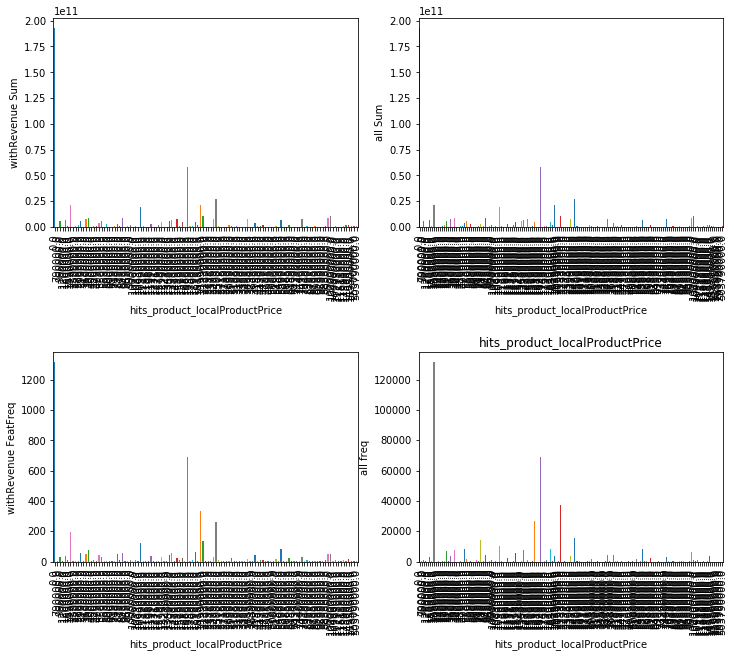

In [239]:
feat_num = 71
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
more_cols.append(feat)
# fill_df_na(feat,0)
# train_df.groupby(feat)[feat].count()
# def clean_domainLookupTime(tag):
#     if tag == 0:
#         return 0
#     else:
#         return 1
# for df in train_df,test_df:
#     print("on dataframe")
#     df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_product_localProductRevenue
------> freq > 0.001 feature is:  Float64Index([0.0], dtype='float64', name='hits_product_localProductRevenue')
 -----> Unique Feature with Revenue/All: 11 11
====>> Unique: [0.0 83.99 10.49 43.84 24.59 576.8 20.656666 5.48 21.49 29.99 21.74]
                                    type uniqueCount NonPer  q01count  q05count  min  max mean
hits_product_localProductRevenue  object          11      0  0.909091  0.909091  NaN  NaN  NaN
None


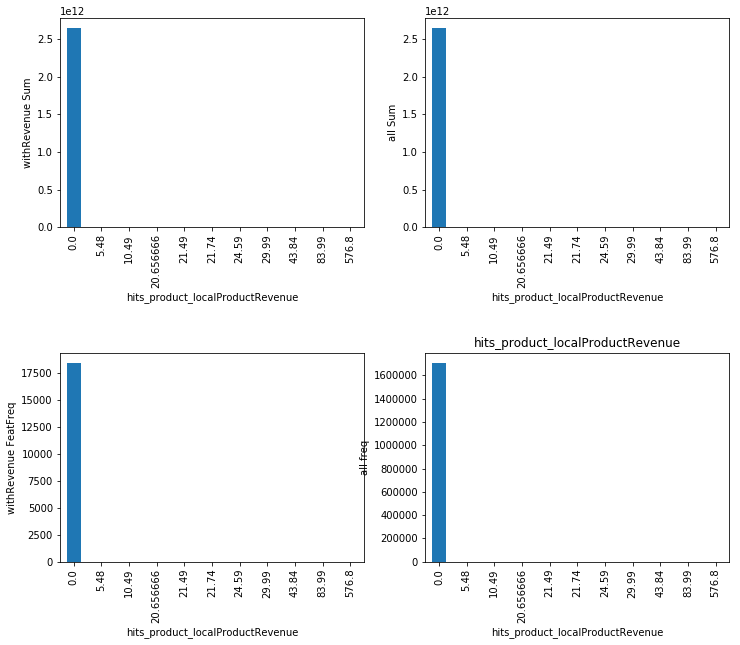

In [253]:
feat_num = 72
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,'other')
# for df in test_df,train_df:
#     df[feat] = df[feat]/1e6
#     print(df[df[feat]=='other'][feat].shape)
#     df.loc[df[feat]=='other',feat] = 0
# train_df.groupby(feat)[feat].count()
# test_df.groupby(feat)[feat].count()
# def clean_domainLookupTime(tag):
#     if tag == 'other':
#         return 'other'
#     else:
#         return 'money'
# for df in train_df,test_df:
#     print("on dataframe")
#     df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_product_productBrand
------> freq > 0.001 feature is:  Index(['(not set)'], dtype='object', name='hits_product_productBrand')
 -----> Unique Feature with Revenue/All: 1 4
====>> Unique: ['(not set)' 'Google' 'YouTube' 'Go']
                             type uniqueCount NonPer q01count q05count  min  max mean
hits_product_productBrand  object           4      0     0.75     0.75  NaN  NaN  NaN
None


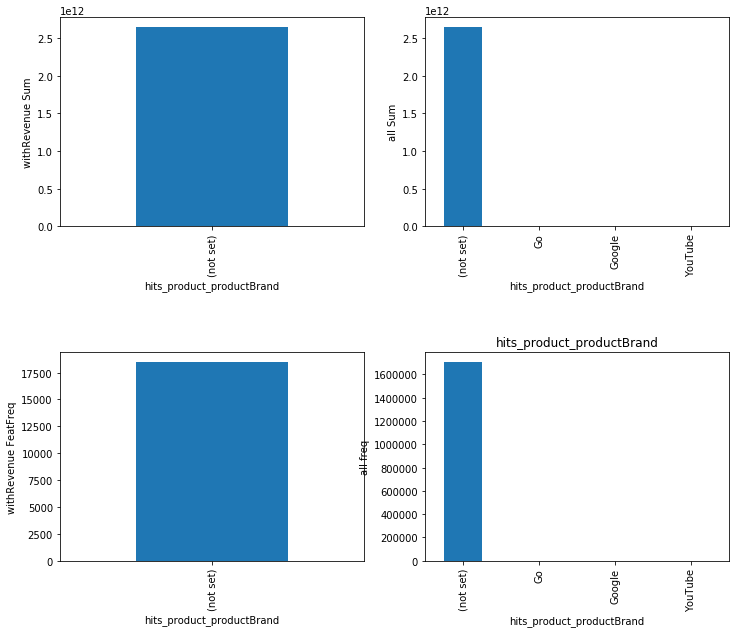

In [257]:
feat_num = 73
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
fill_df_na(feat,'(not set)')
# for df in test_df,train_df:
#     df[feat] = df[feat]/1e6
#     print(df[df[feat]=='other'][feat].shape)
#     df.loc[df[feat]=='other',feat] = 0
# train_df.groupby(feat)[feat].count()
# test_df.groupby(feat)[feat].count()
# def clean_domainLookupTime(tag):
#     if tag == 'other':
#         return 'other'
#     else:
#         return 'money'
# for df in train_df,test_df:
#     print("on dataframe")
#     df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))

----> Work on feature: hits_product_productCouponCode
------> freq > 0.001 feature is:  Index(['(not set)'], dtype='object', name='hits_product_productCouponCode')
 -----> Unique Feature with Revenue/All: 1 1
====>> Unique: [nan '(not set)']
                                  type uniqueCount   NonPer q01count q05count  min  max mean
hits_product_productCouponCode  object           2  99.5468        0        1  NaN  NaN  NaN
None


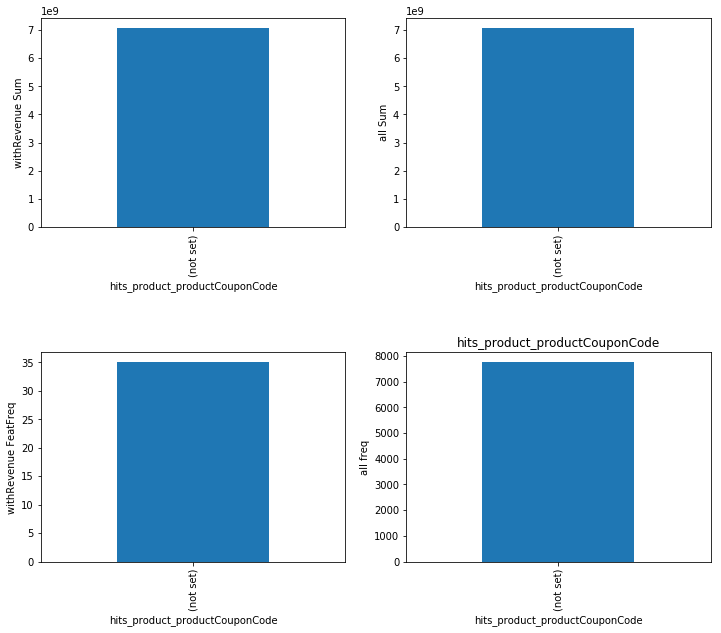

In [258]:
feat_num = 74
feat = train_df.columns[feat_num]
print("----> Work on feature:",feat)
check_me2(feat,train_df)


# to_drop.append(feat)
# cat_cols.append(feat)
# num_cols.append(feat)
# more_cols.append(feat)
# fill_df_na(feat,'other')
# for df in test_df,train_df:
#     df[feat] = df[feat]/1e6
#     print(df[df[feat]=='other'][feat].shape)
#     df.loc[df[feat]=='other',feat] = 0
# train_df.groupby(feat)[feat].count()
# test_df.groupby(feat)[feat].count()
# def clean_domainLookupTime(tag):
#     if tag == 'other':
#         return 'other'
#     else:
#         return 'money'
# for df in train_df,test_df:
#     print("on dataframe")
#     df[feat] = df[feat].apply(lambda x: clean_domainLookupTime(x))